# Visualize real data

Get to know the real data

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

E:\Users\MichaelHopwood\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Users\MichaelHopwood\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
E:\Users\MichaelHopwood\miniconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [3]:
folder = 'data'
df = pd.read_excel(os.path.join(folder, '20211128 - Full DART Data (Model & Test).xlsx'), header=2)
df.head()

,Sample,Class,Sample Types,SRN,59.00498,72.00792,74.00967,75.00427,77.00585,77.00646,...,534.22864,545.23129,548.2292,564.22822,578.23102,589.23387,592.23132,608.23108,622.23371,636.23384
0,1,c1,Model,SRN00001_DART_NHM_1,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,c1,Model,SRN00001_DART_NHM_2,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,c1,Model,SRN00001_DART_NHM_3,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,c2,Model,SRN00002_DART_NHM_1,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,c2,Model,SRN00002_DART_NHM_2,0.0,0.0,0.0,5.83,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


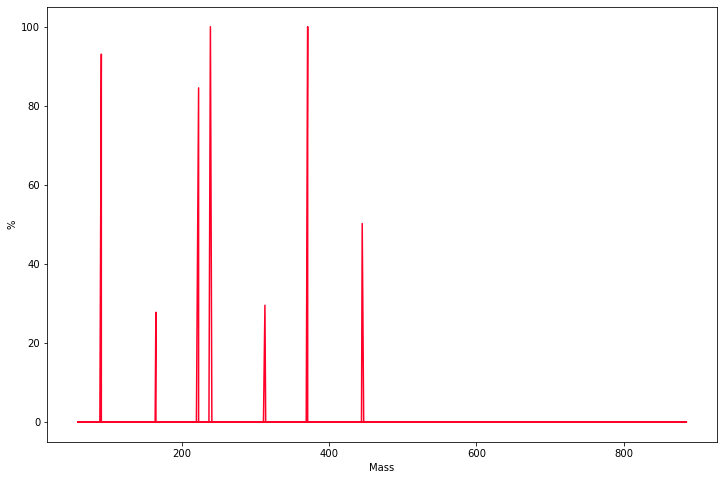

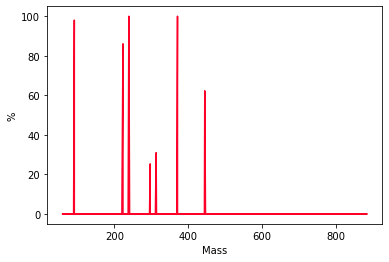

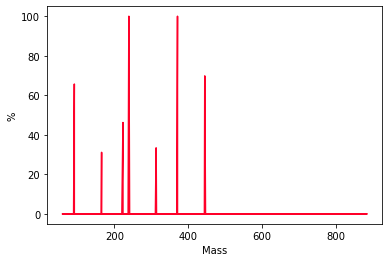

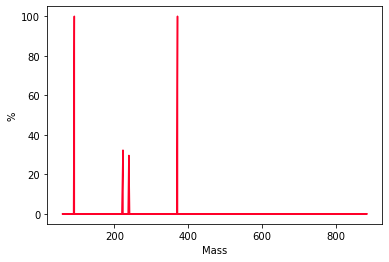

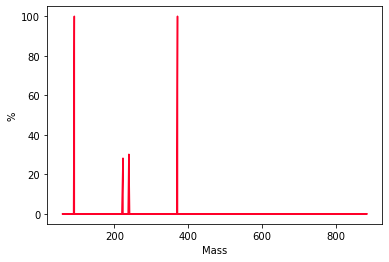

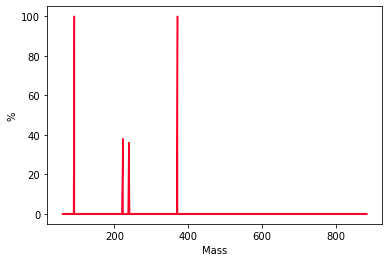

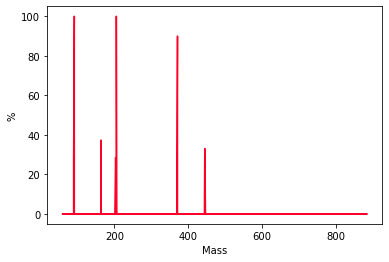

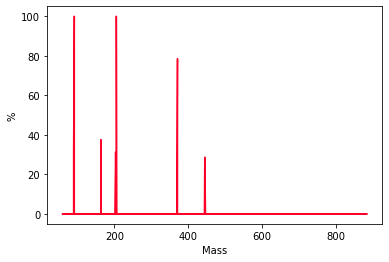

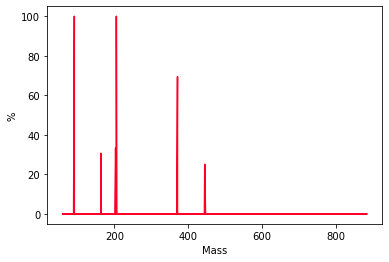

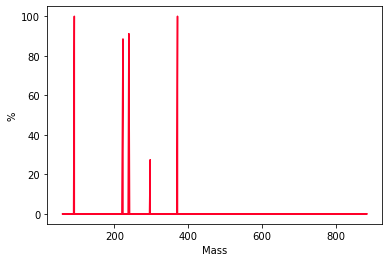

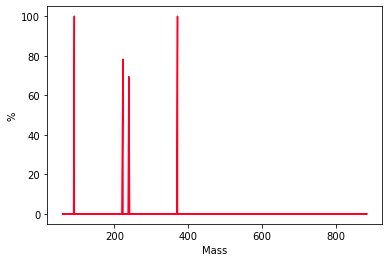

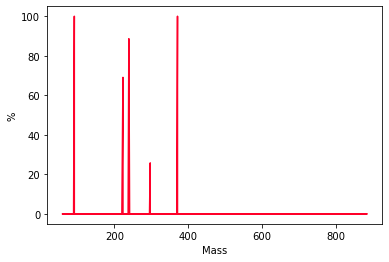

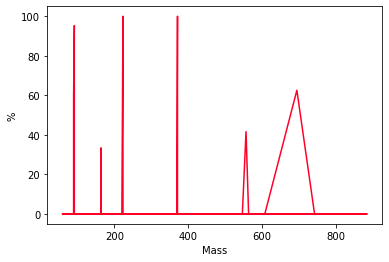

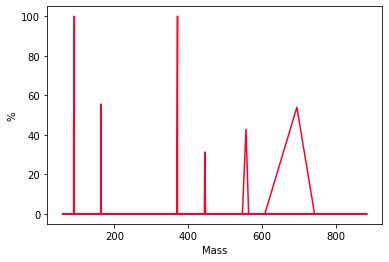

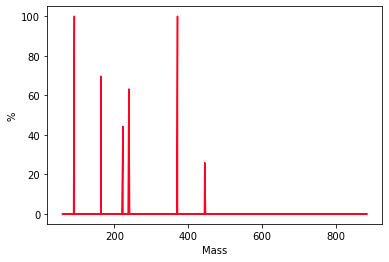

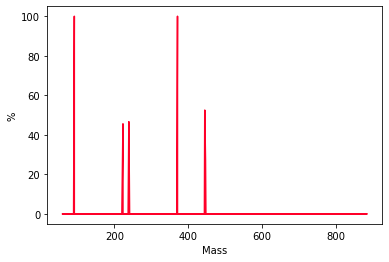

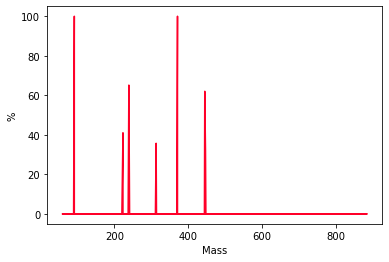

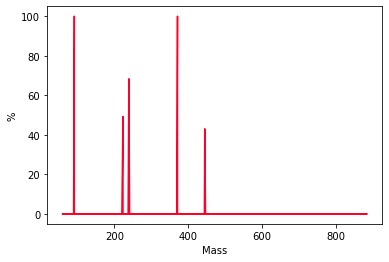

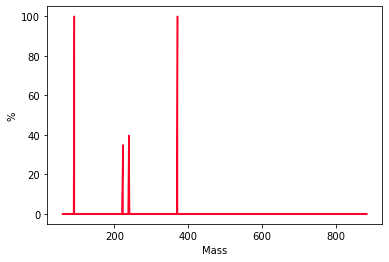

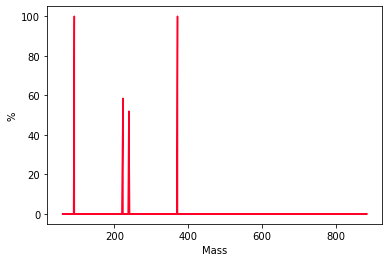

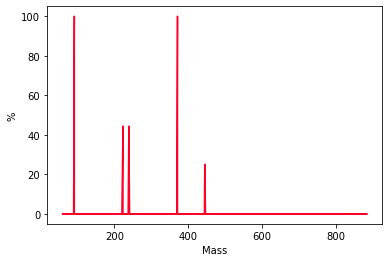

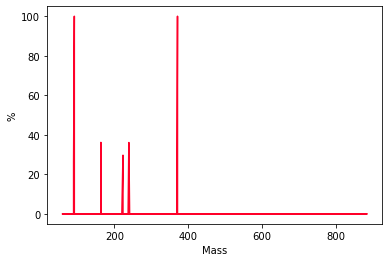

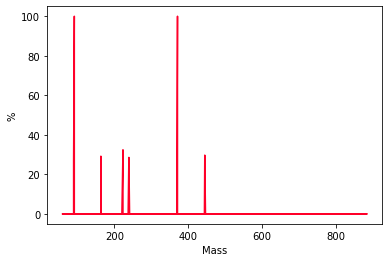

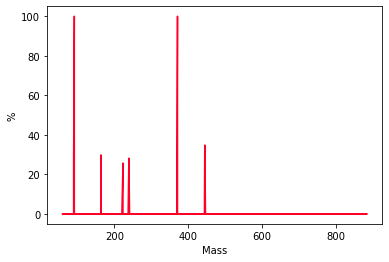

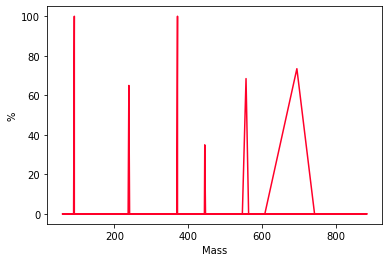

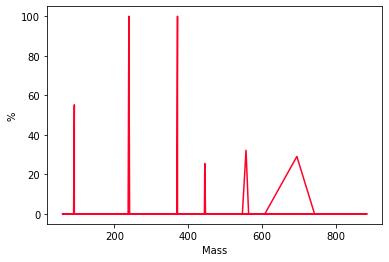

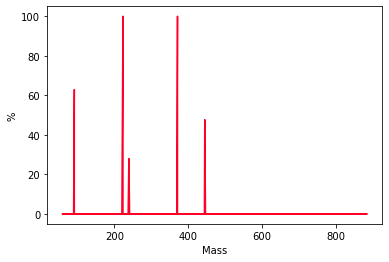

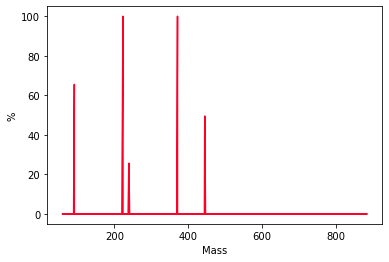

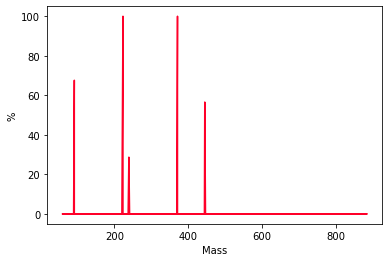

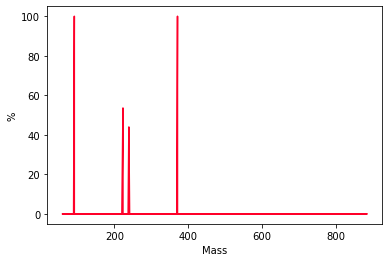

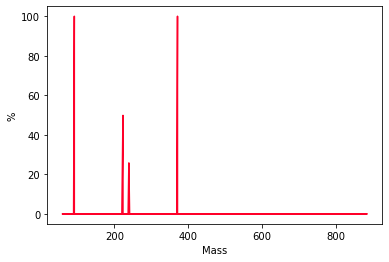

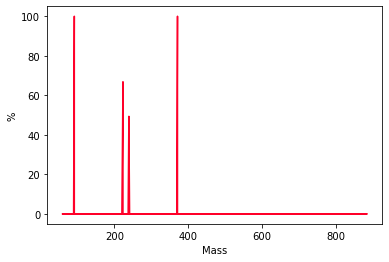

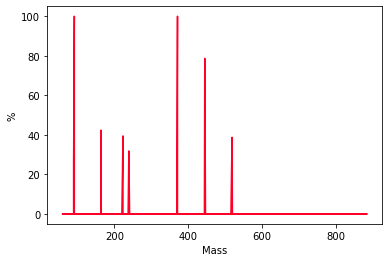

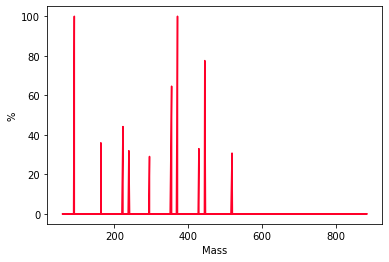

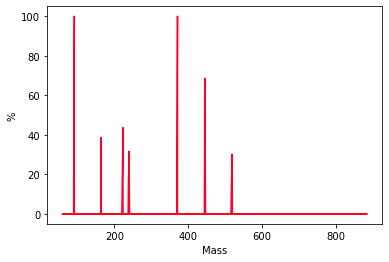

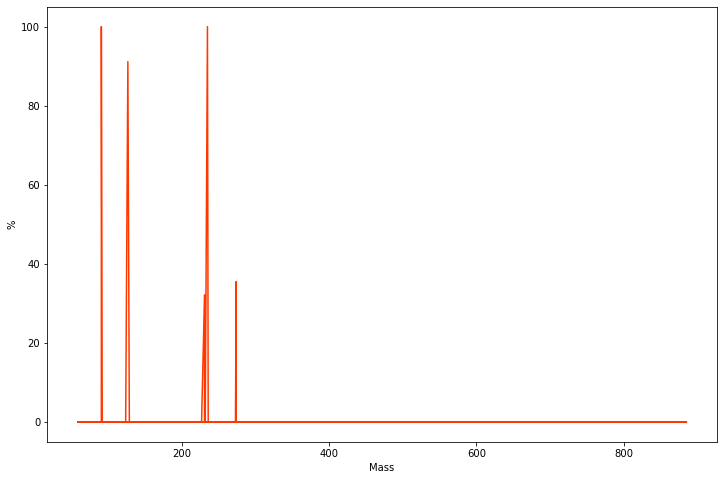

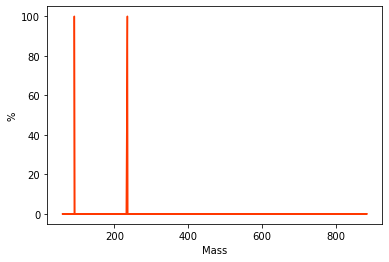

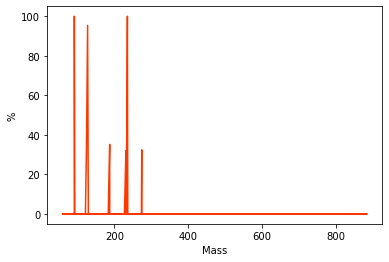

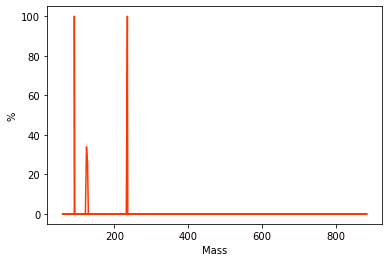

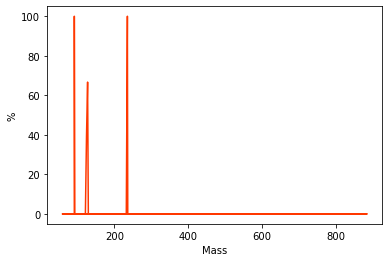

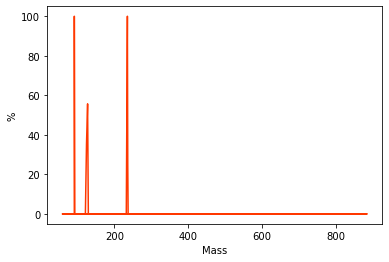

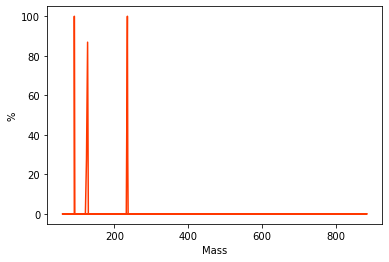

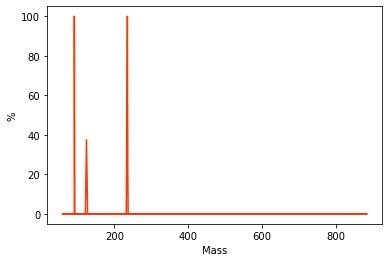

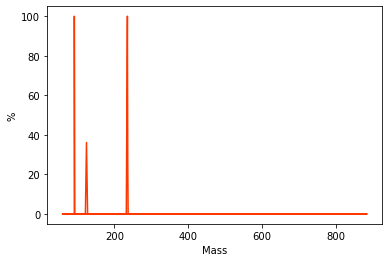

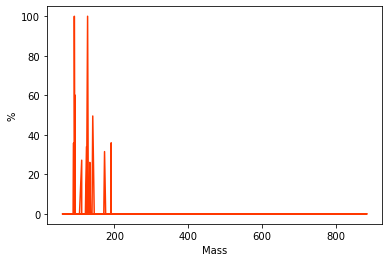

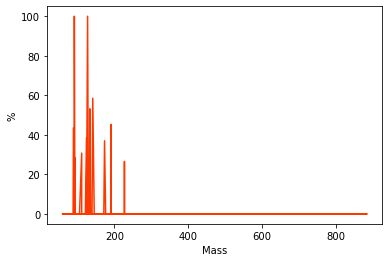

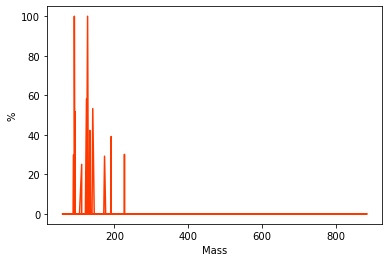

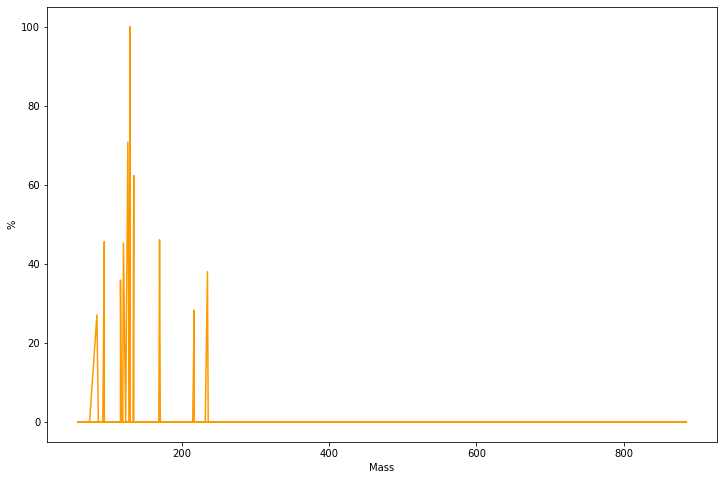

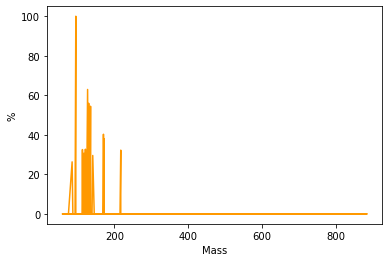

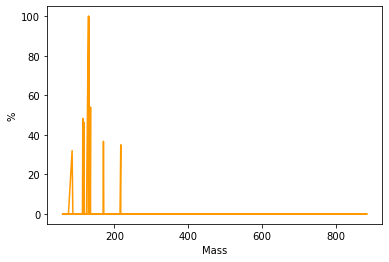

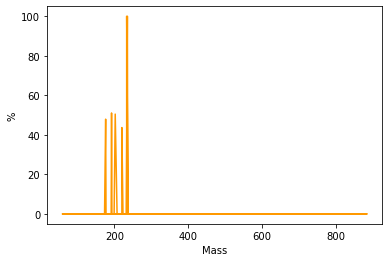

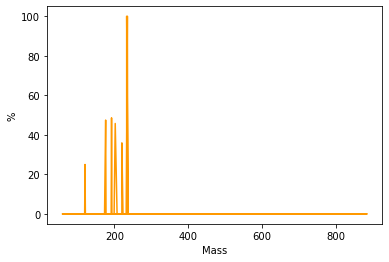

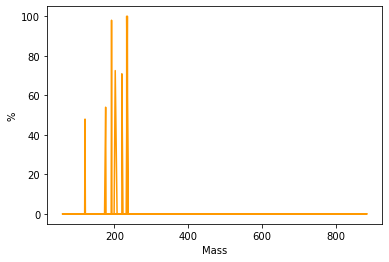

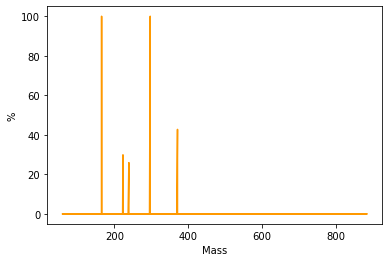

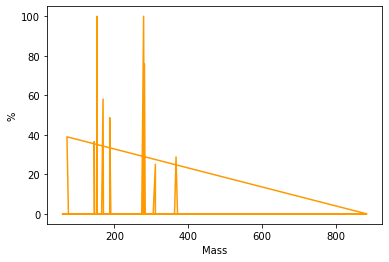

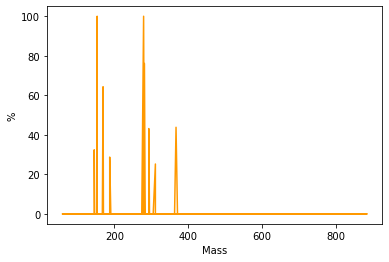

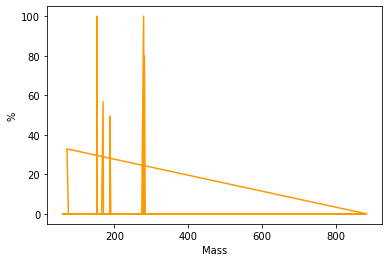

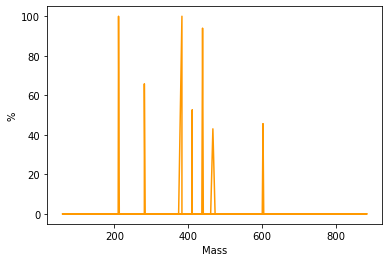

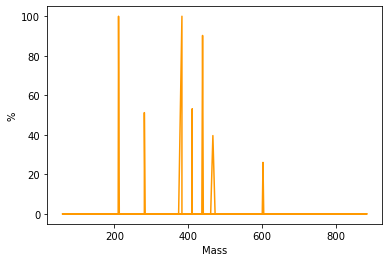

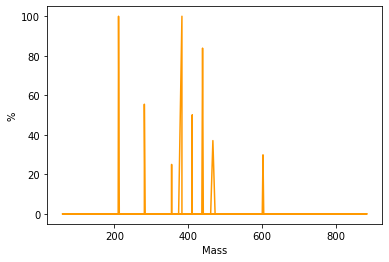

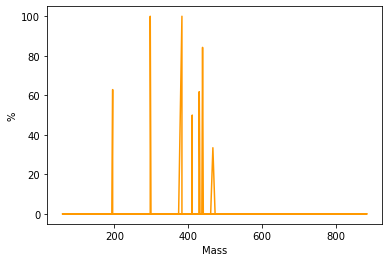

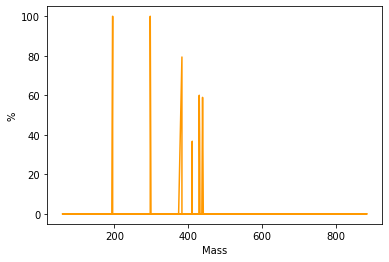

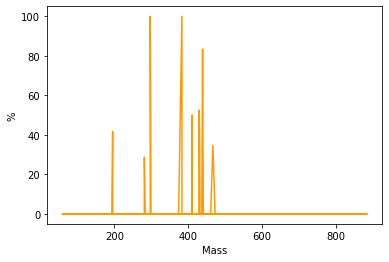

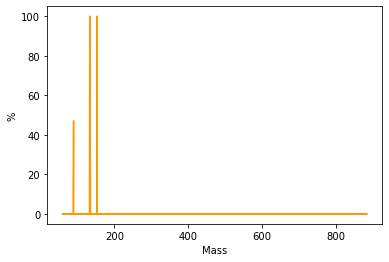

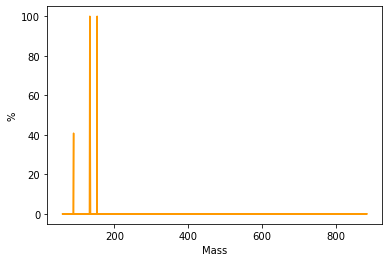

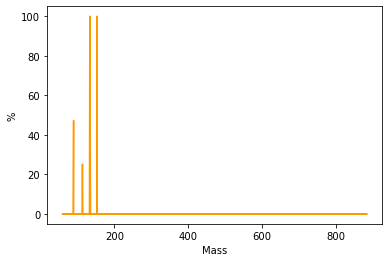

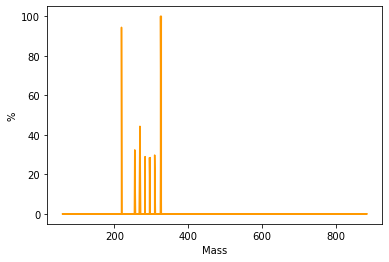

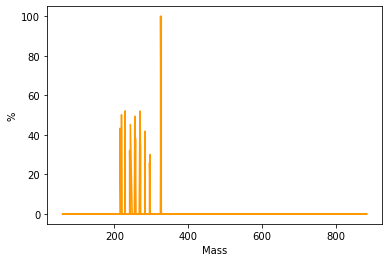

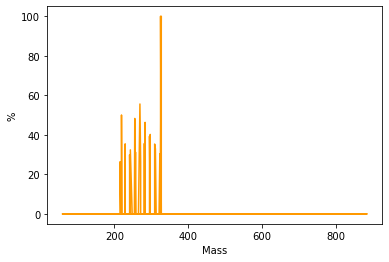

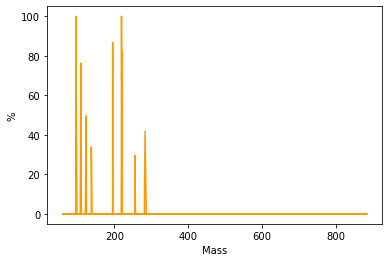

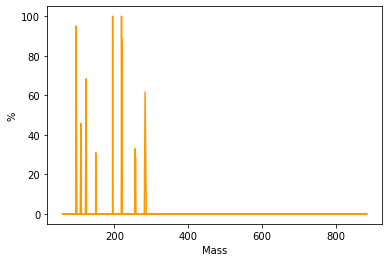

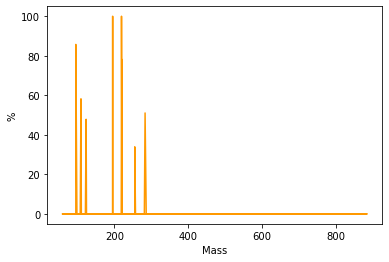

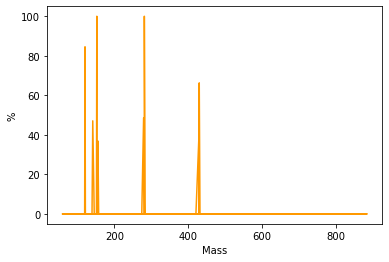

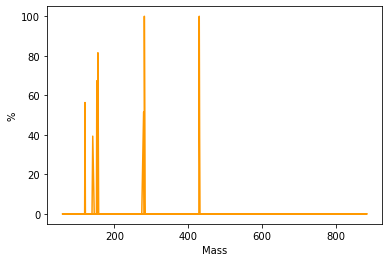

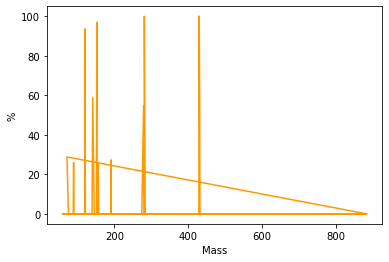

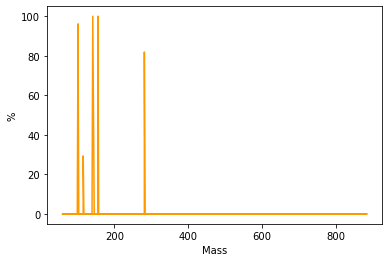

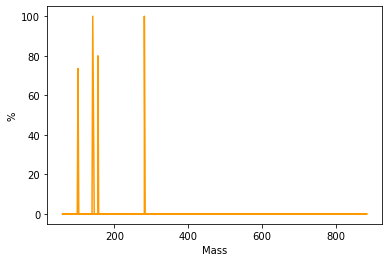

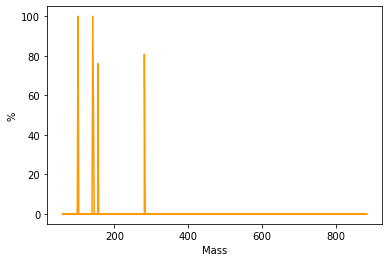

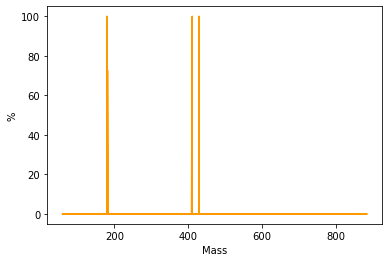

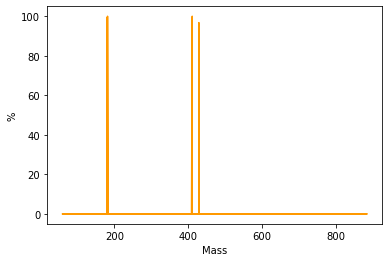

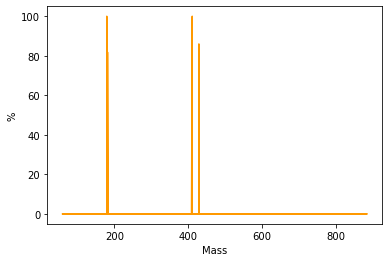

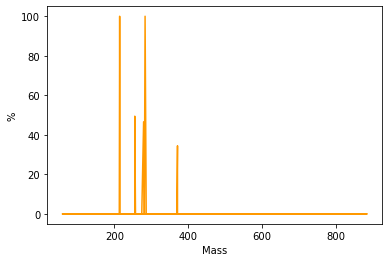

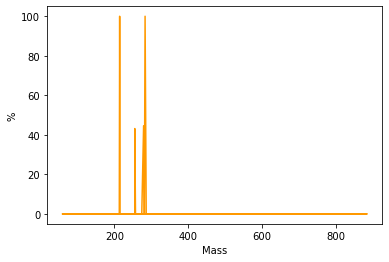

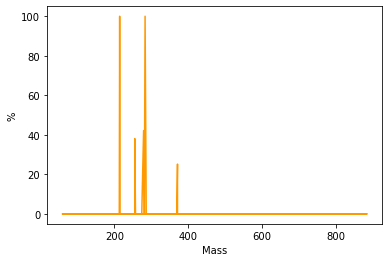

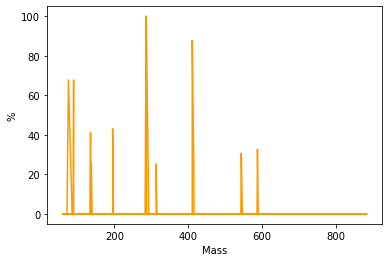

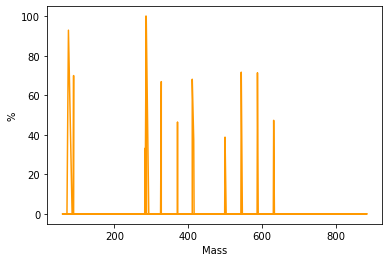

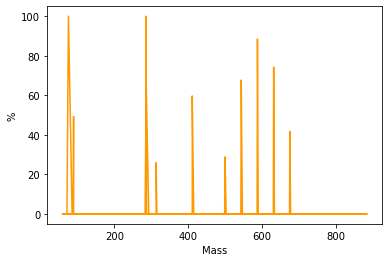

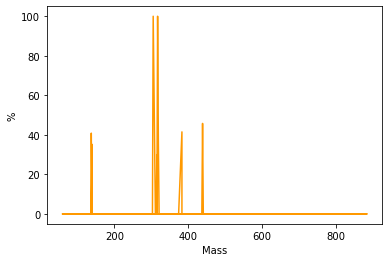

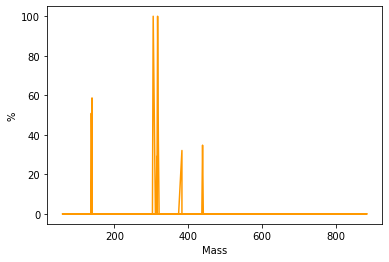

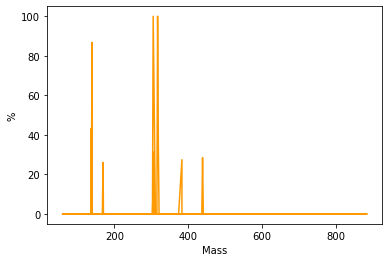

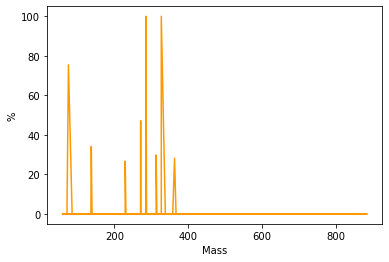

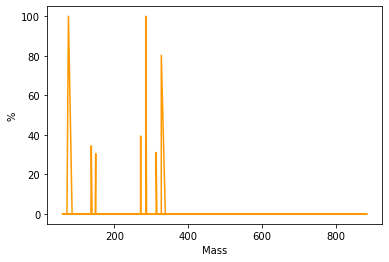

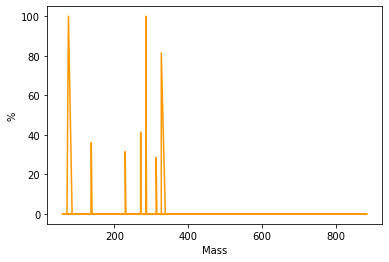

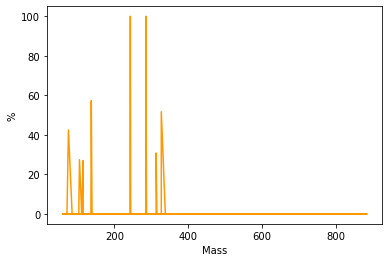

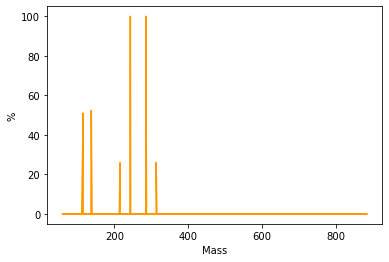

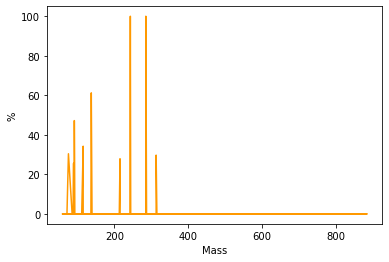

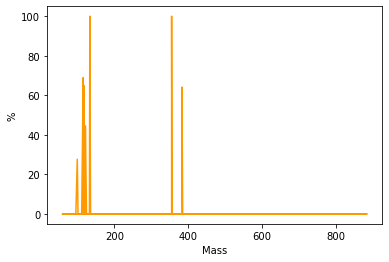

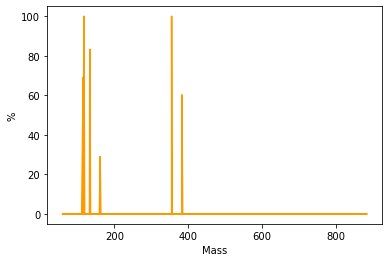

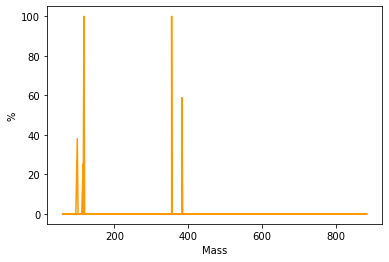

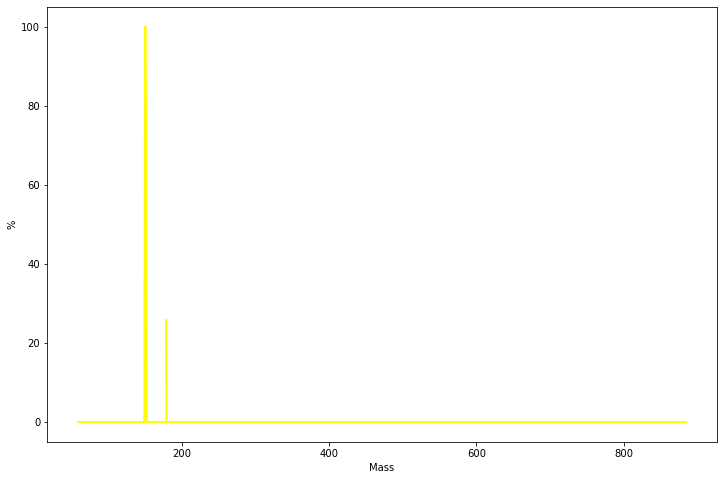

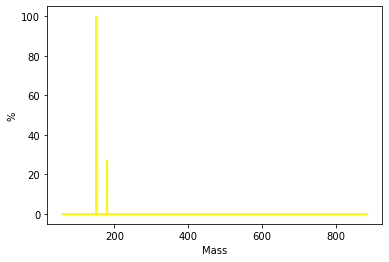

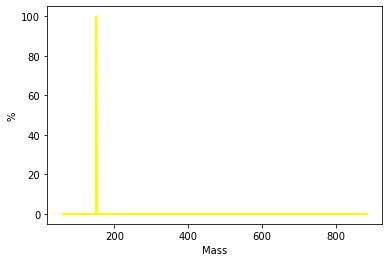

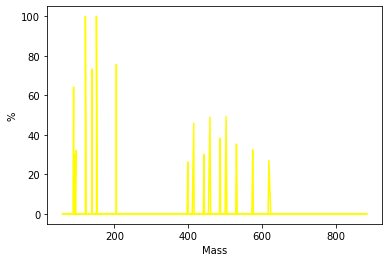

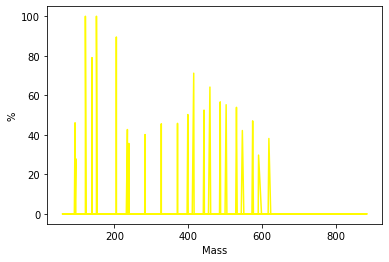

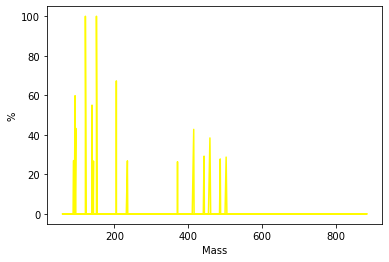

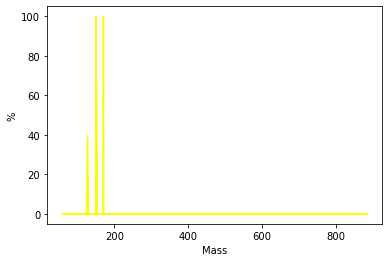

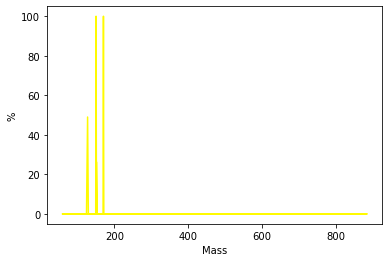

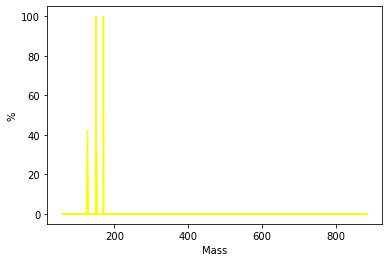

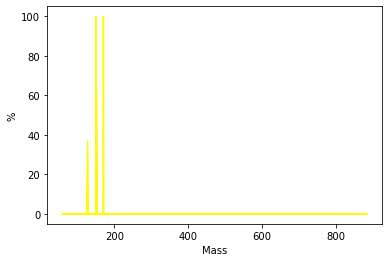

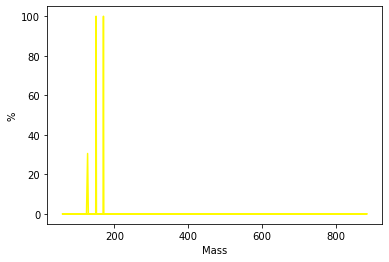

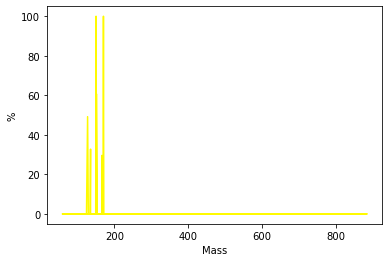

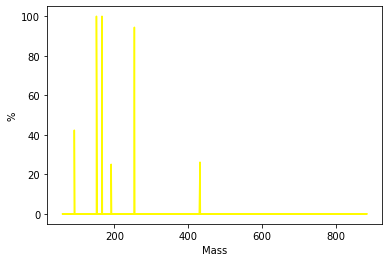

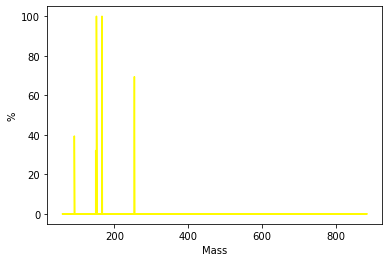

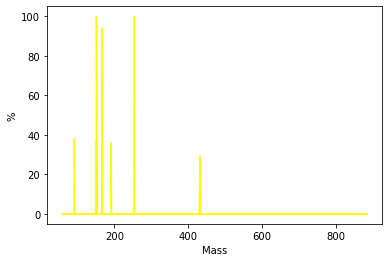

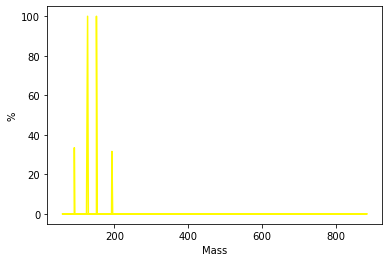

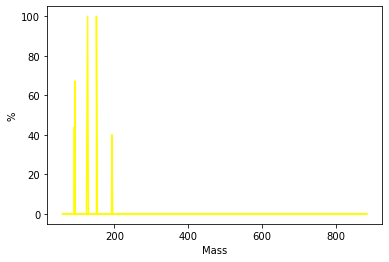

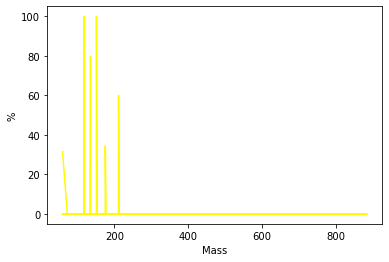

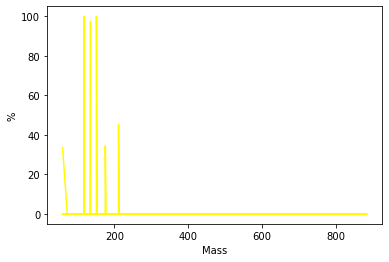

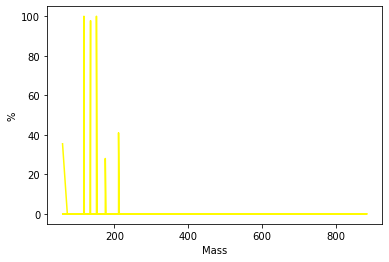

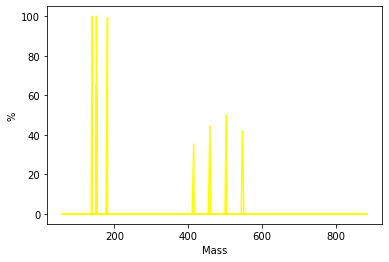

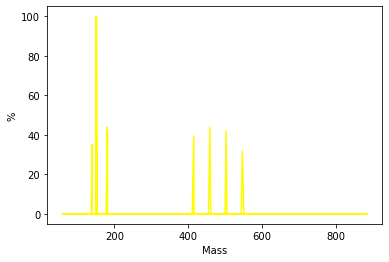

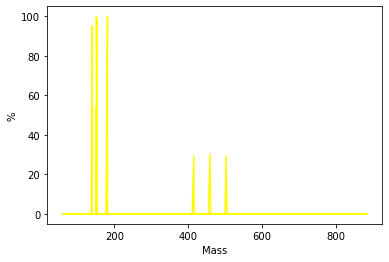

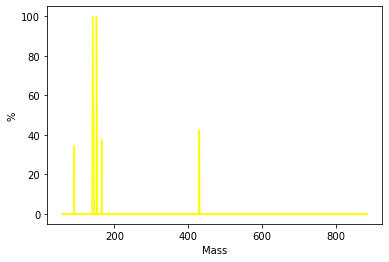

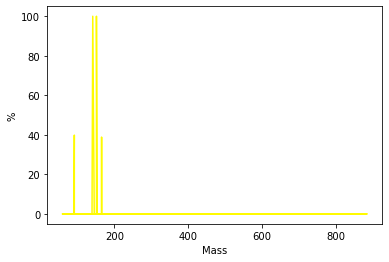

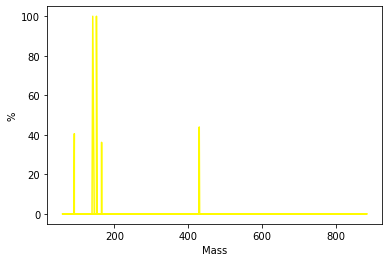

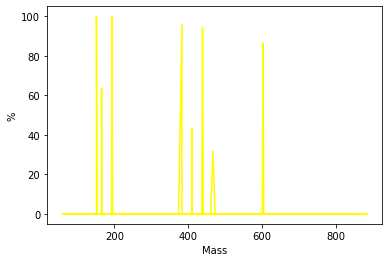

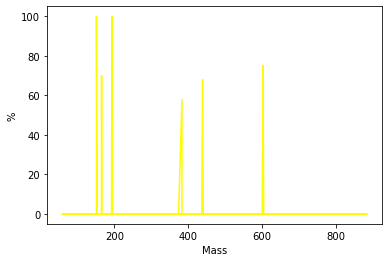

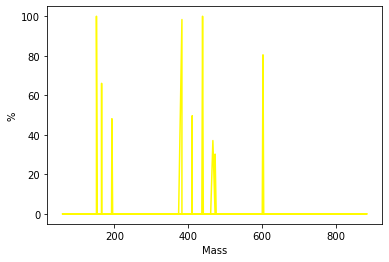

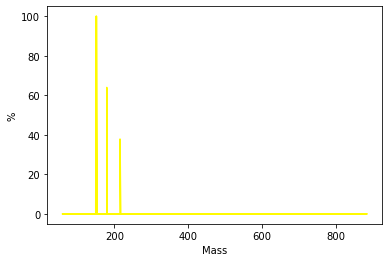

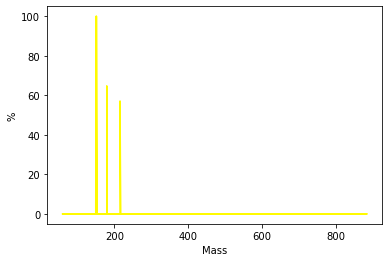

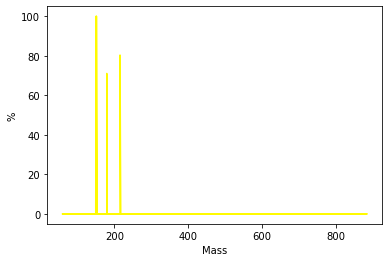

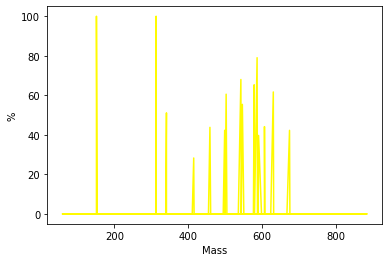

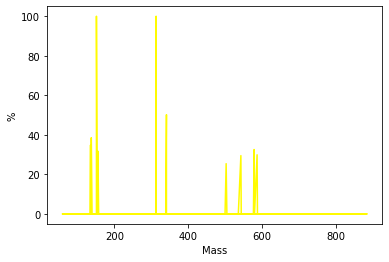

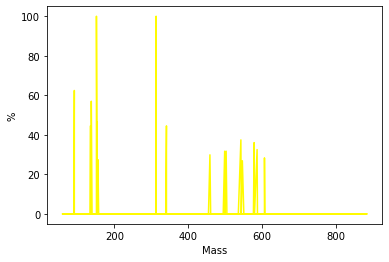

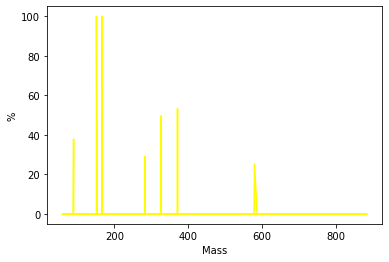

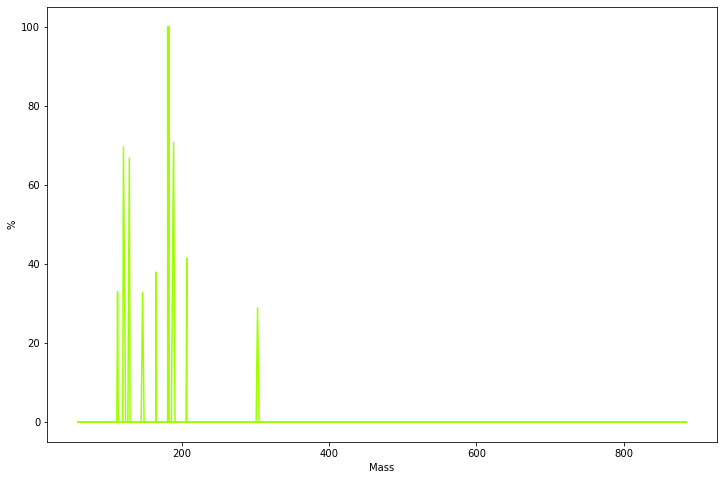

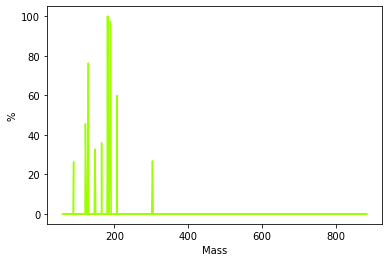

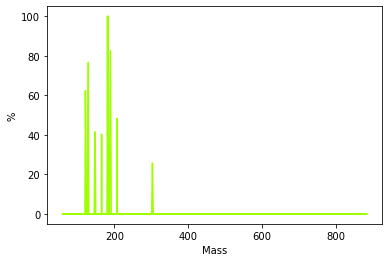

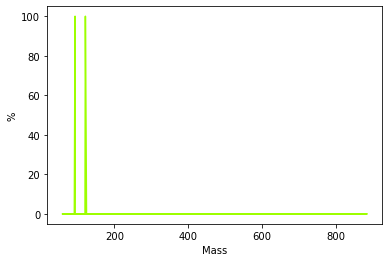

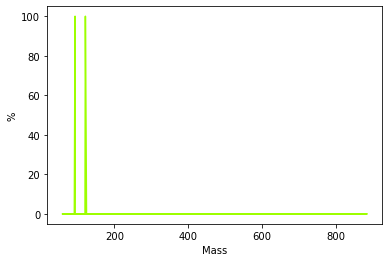

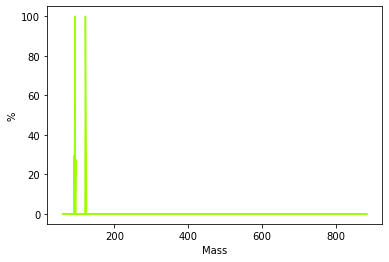

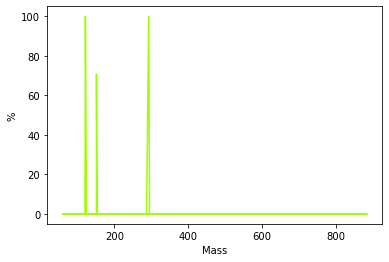

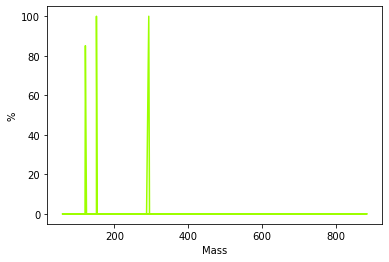

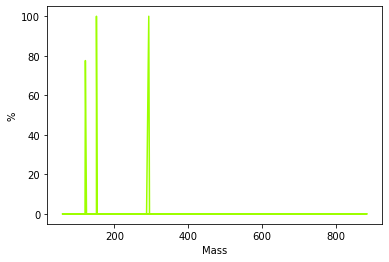

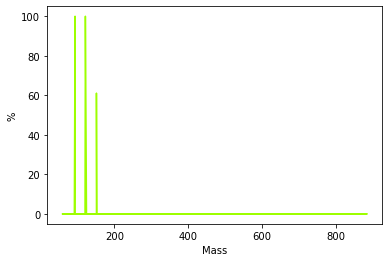

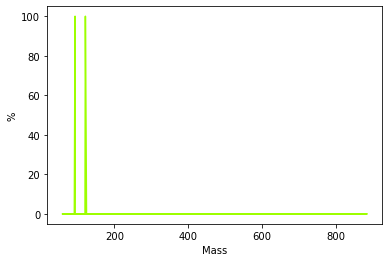

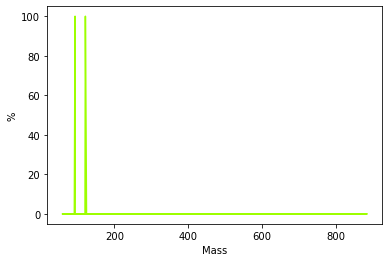

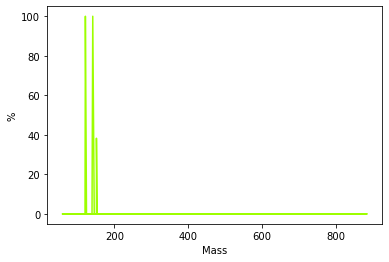

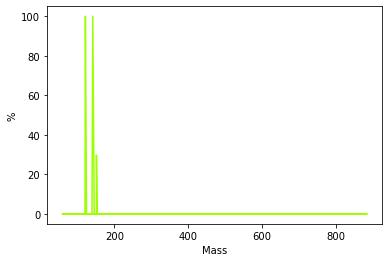

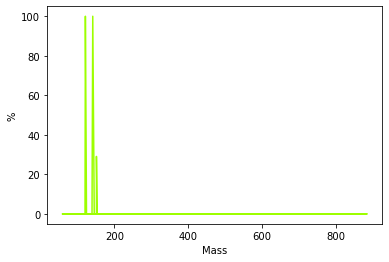

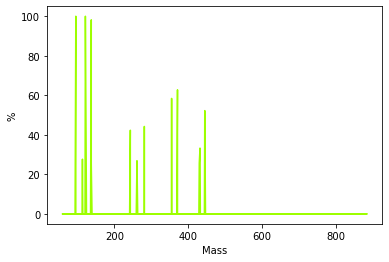

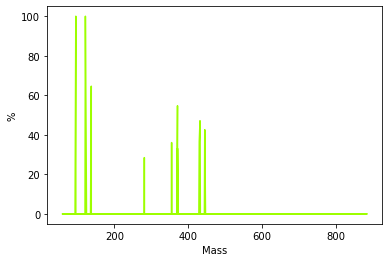

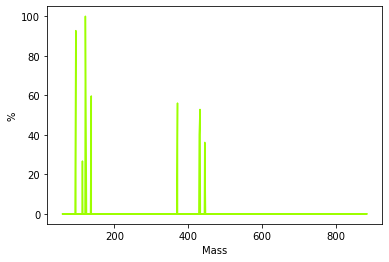

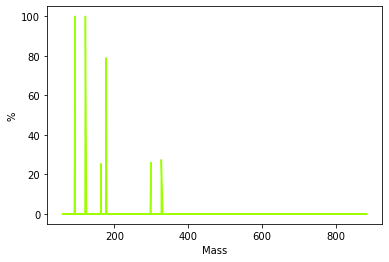

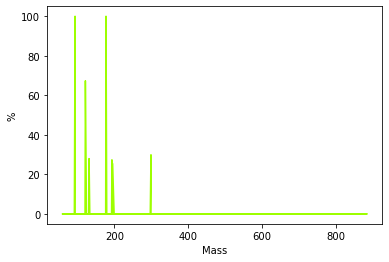

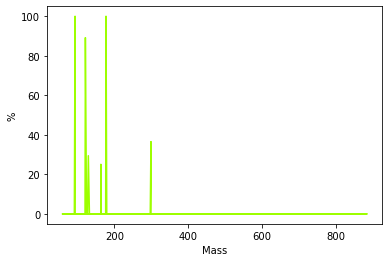

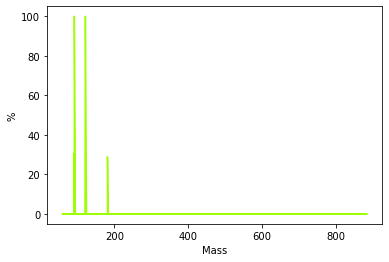

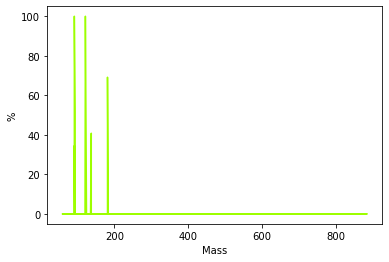

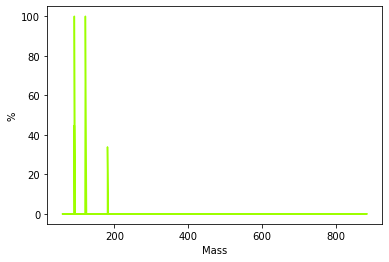

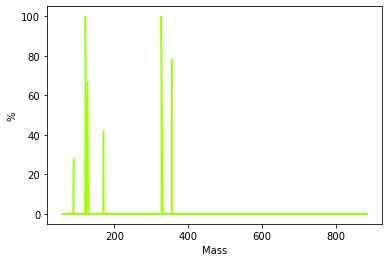

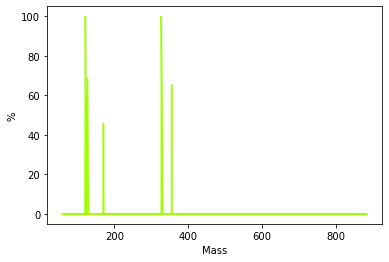

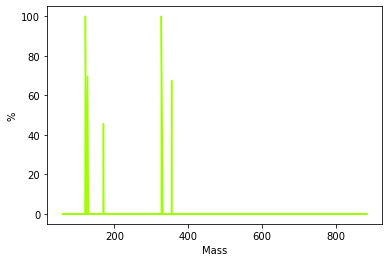

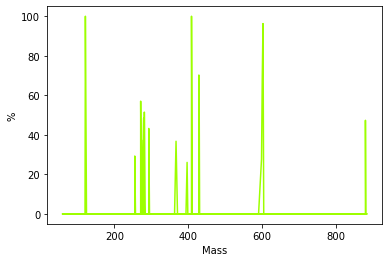

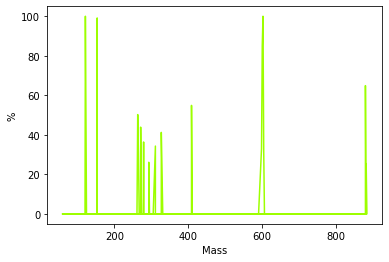

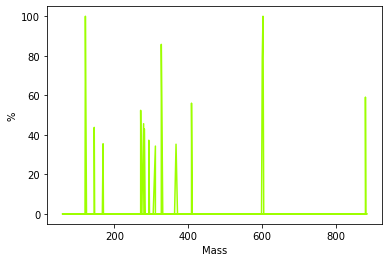

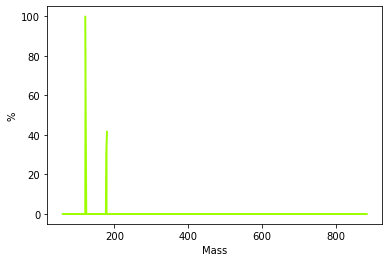

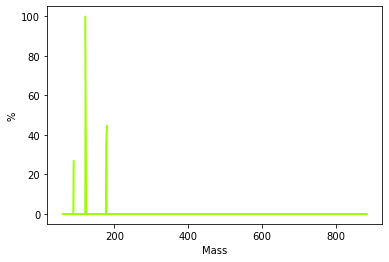

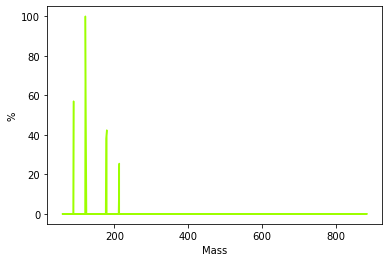

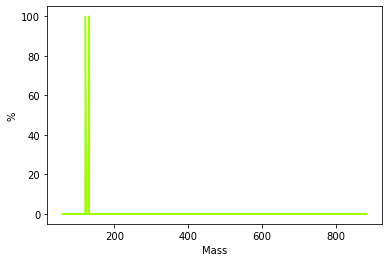

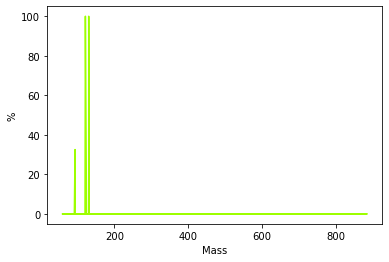

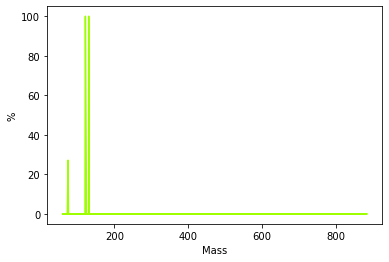

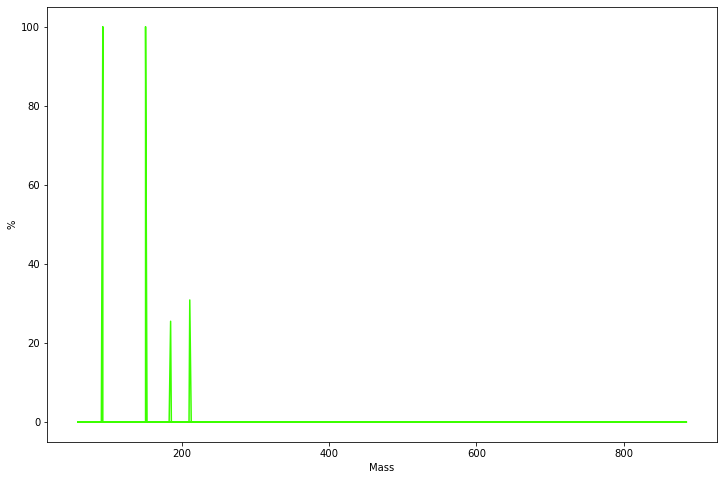

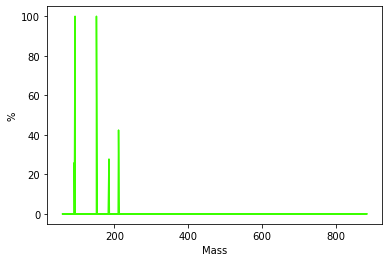

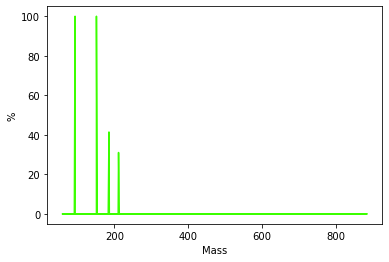

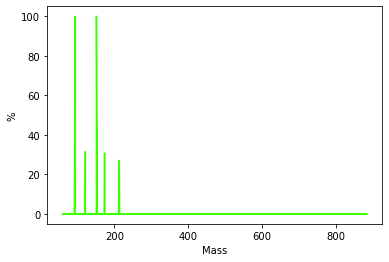

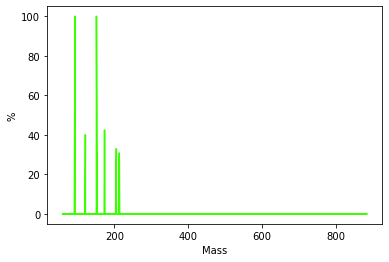

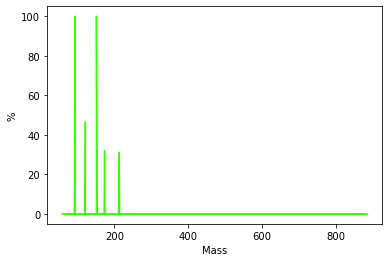

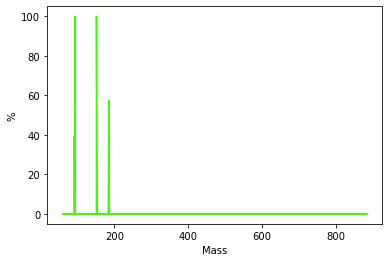

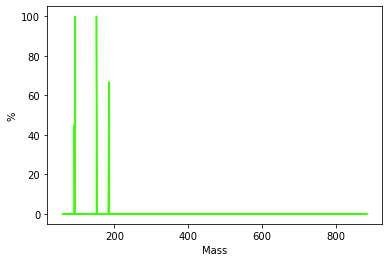

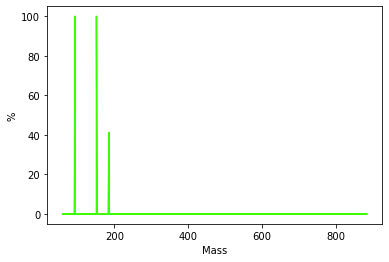

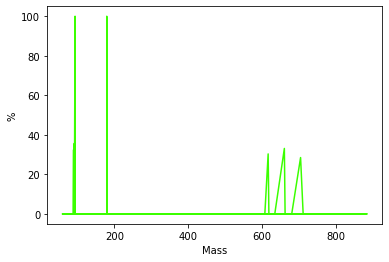

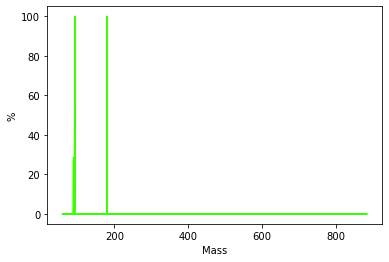

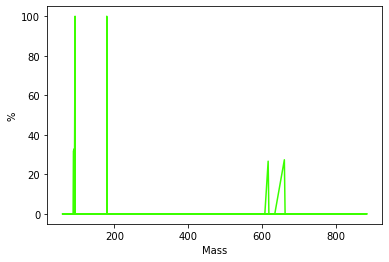

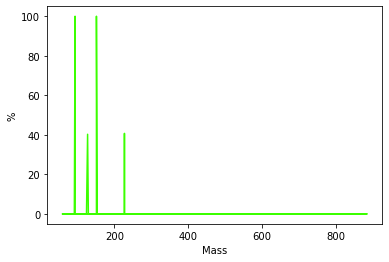

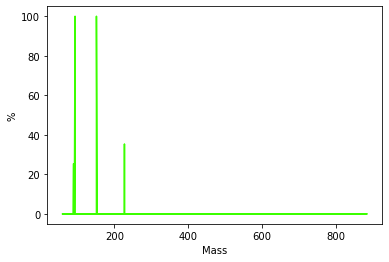

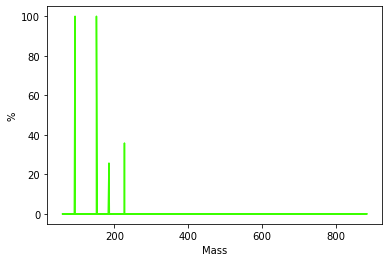

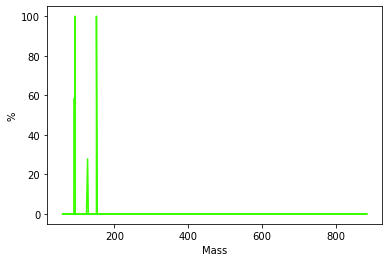

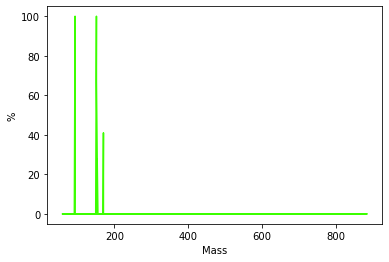

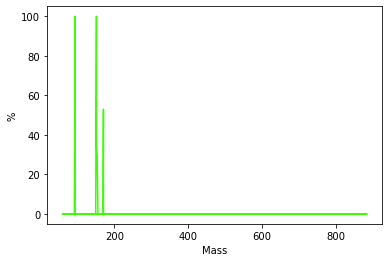

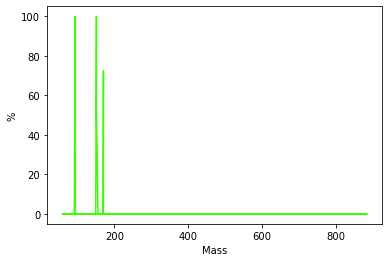

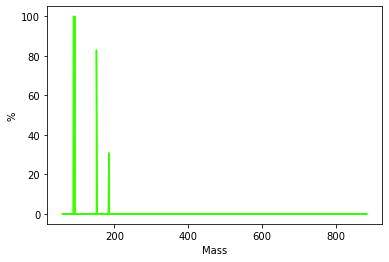

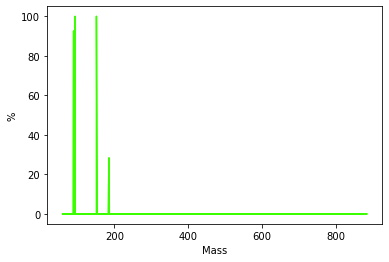

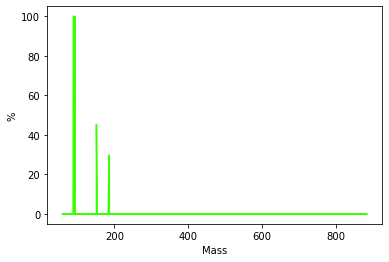

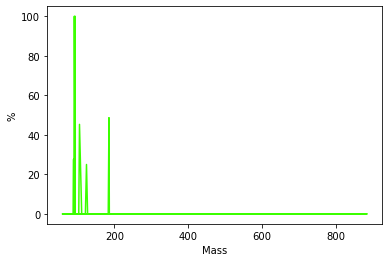

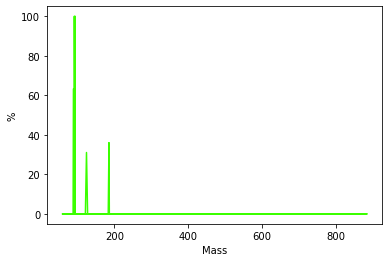

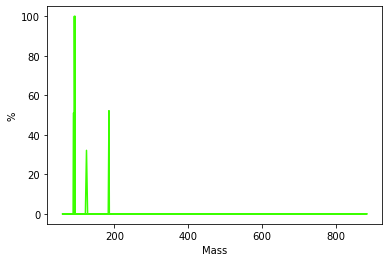

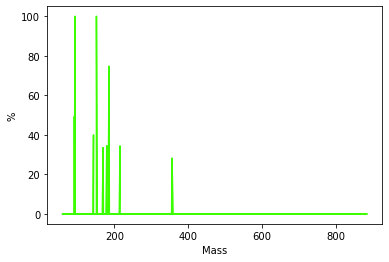

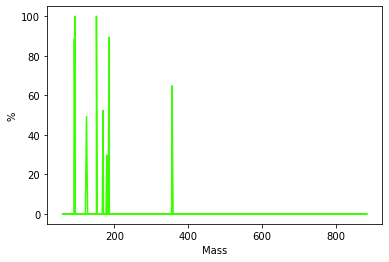

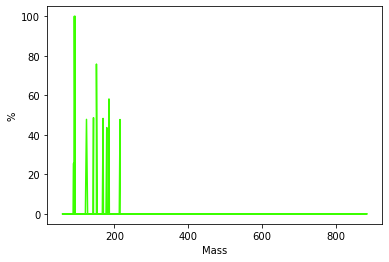

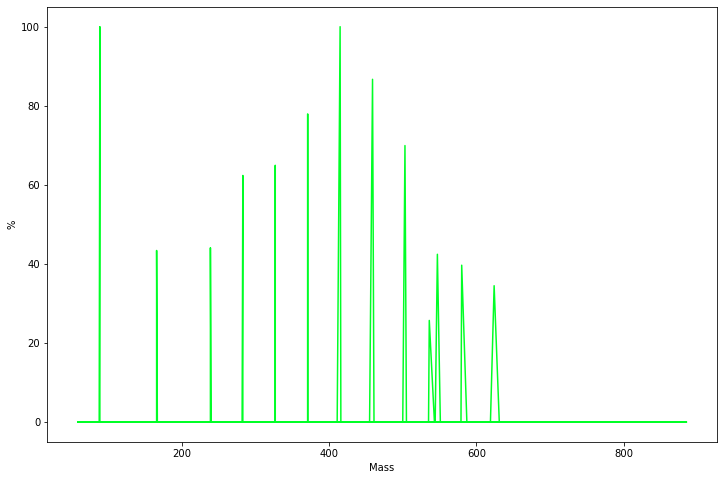

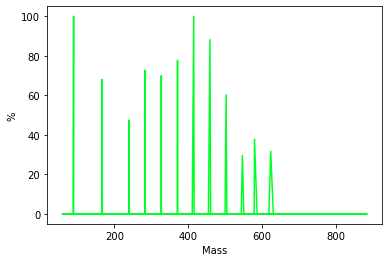

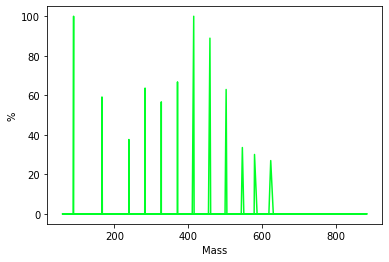

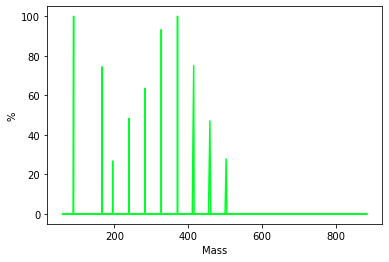

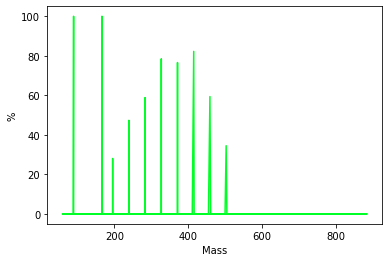

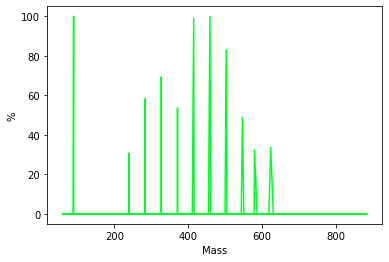

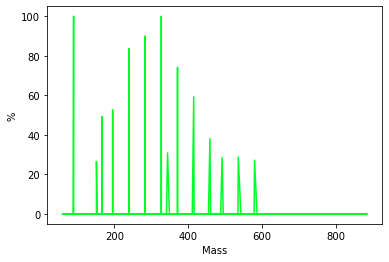

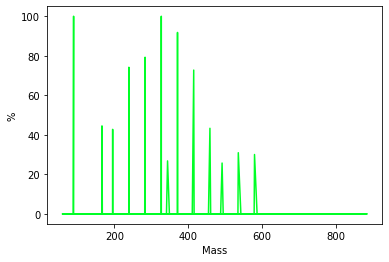

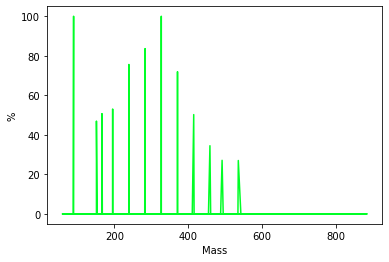

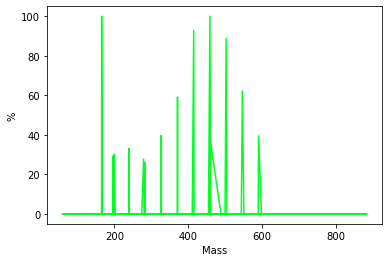

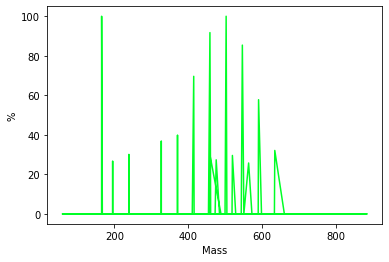

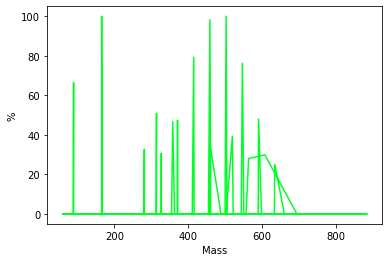

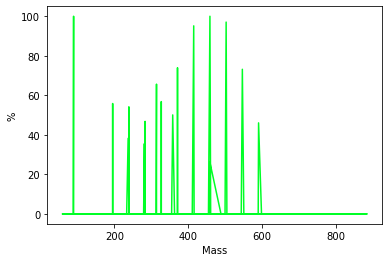

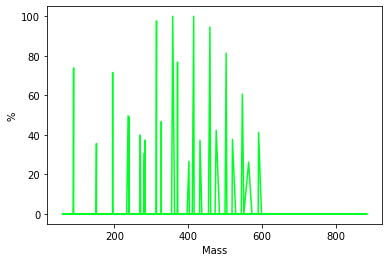

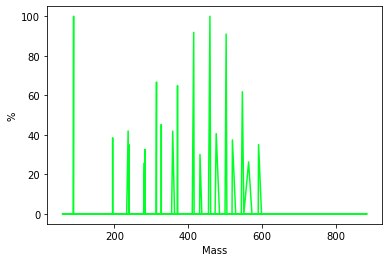

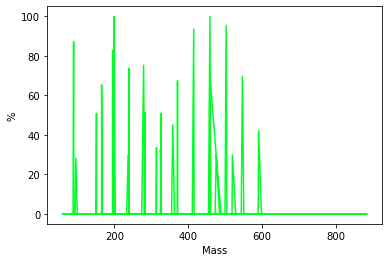

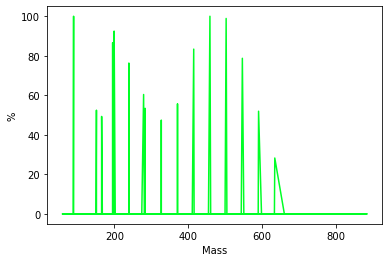

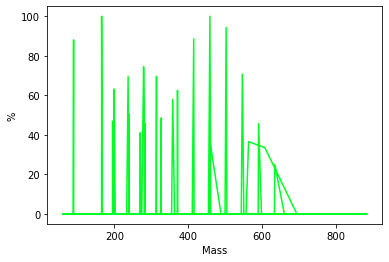

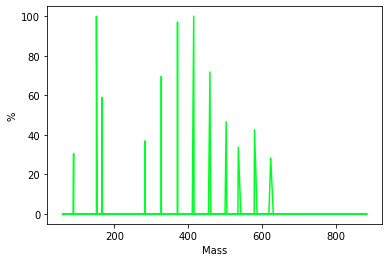

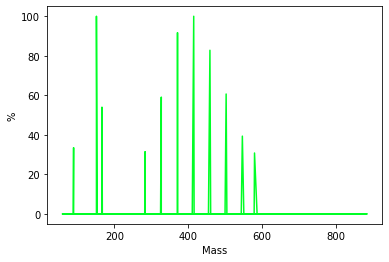

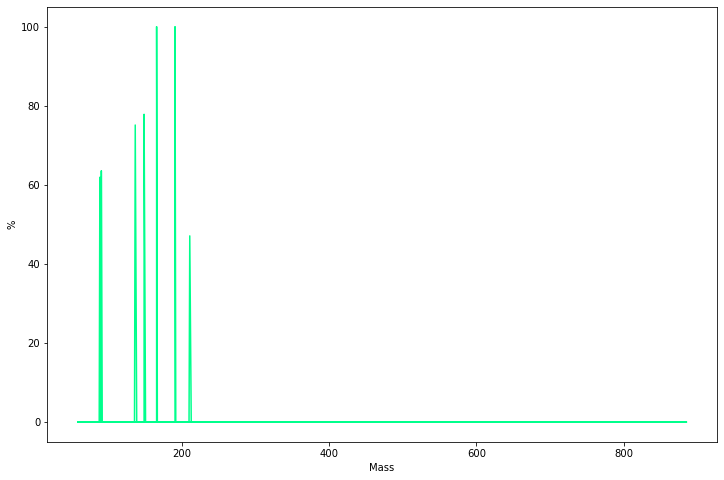

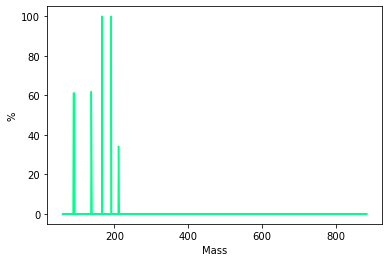

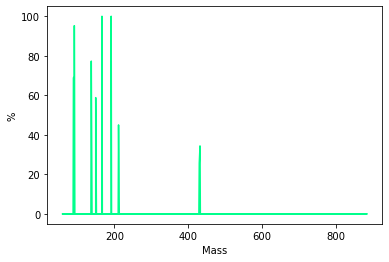

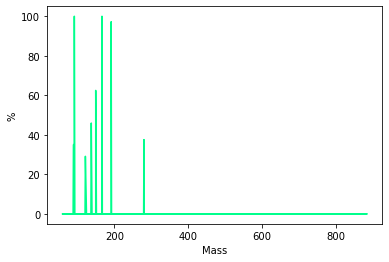

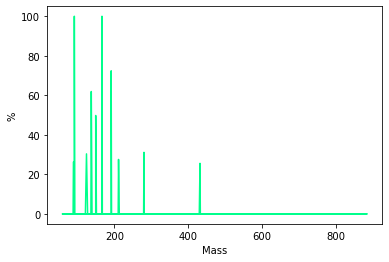

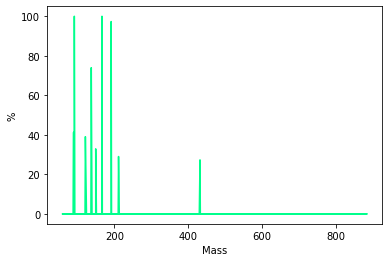

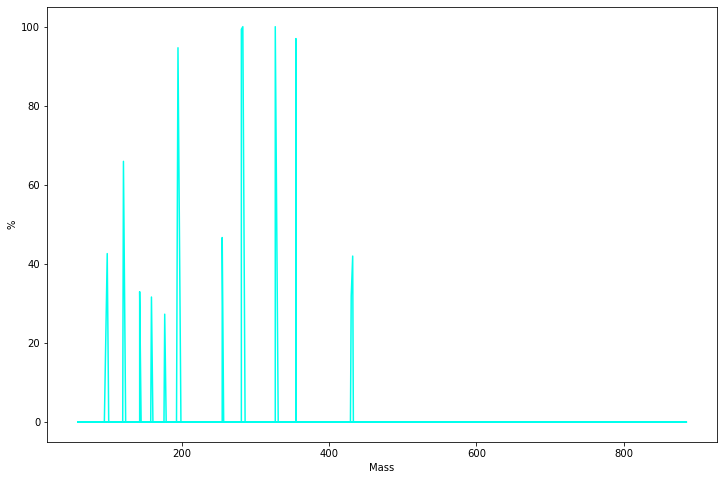

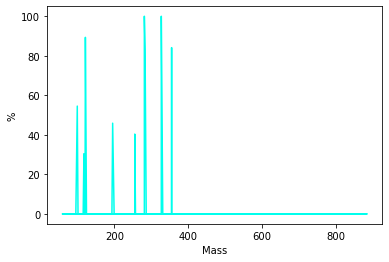

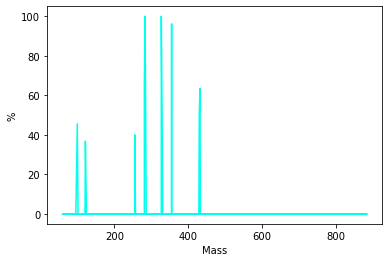

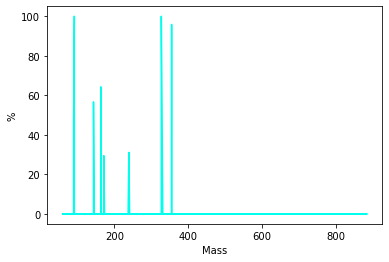

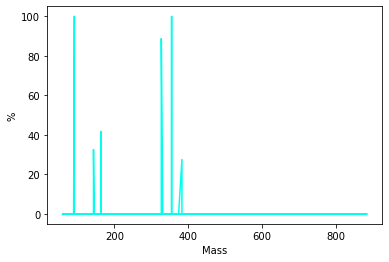

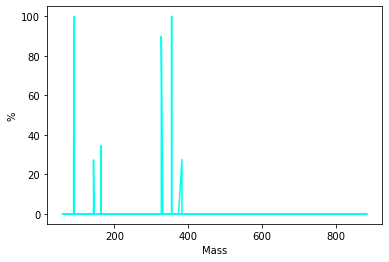

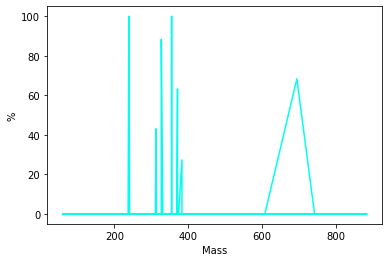

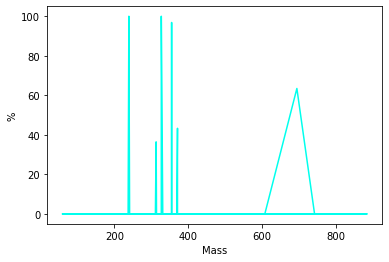

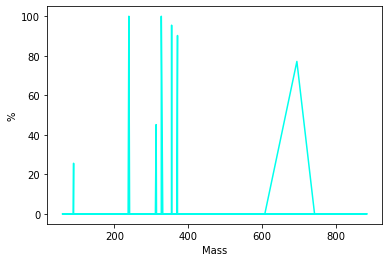

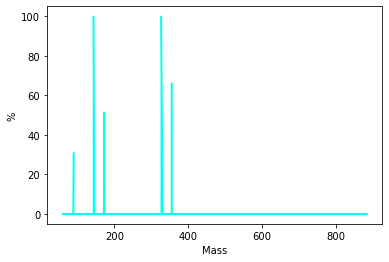

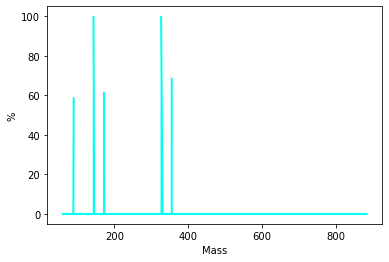

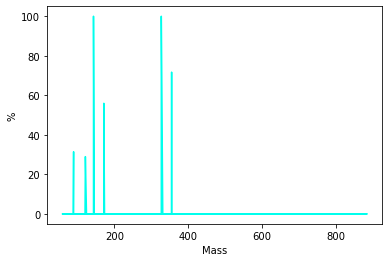

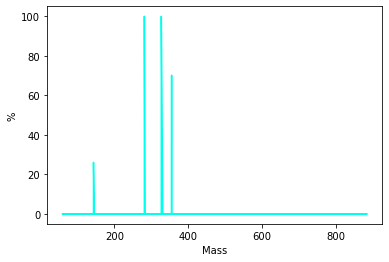

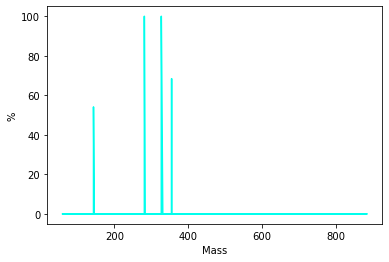

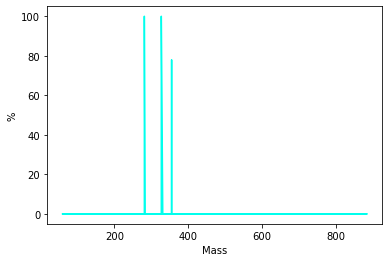

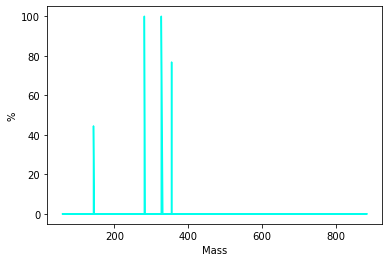

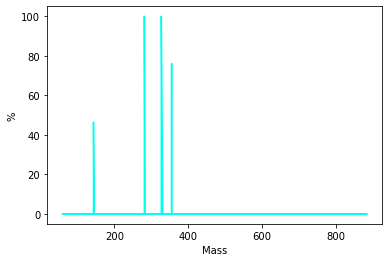

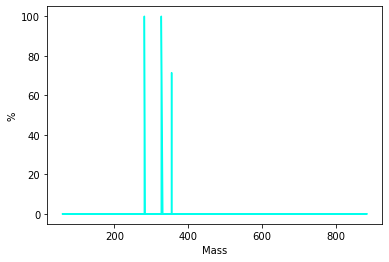

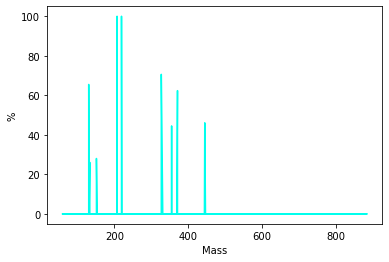

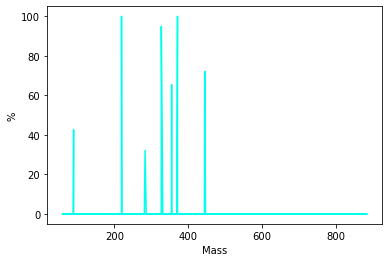

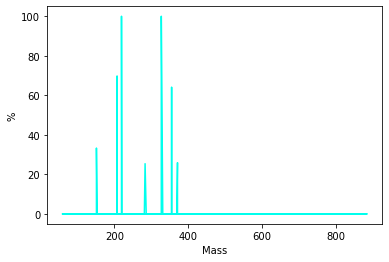

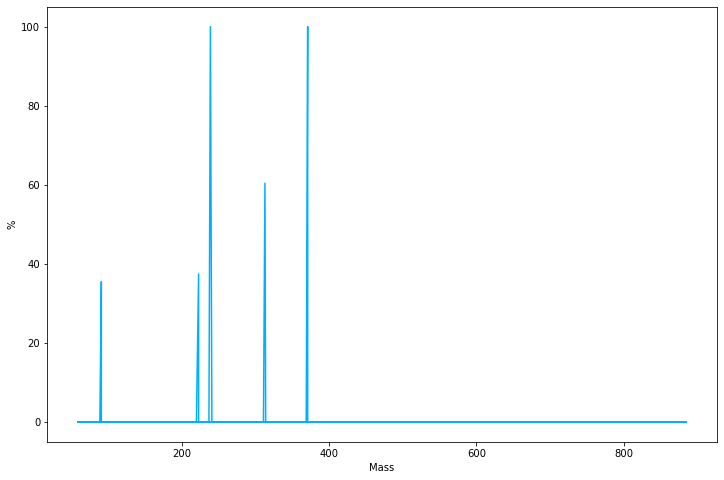

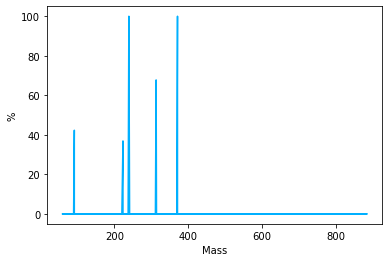

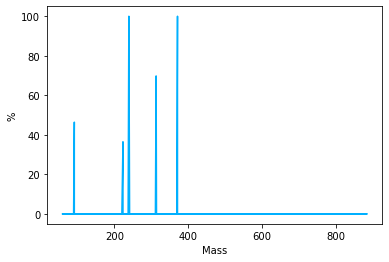

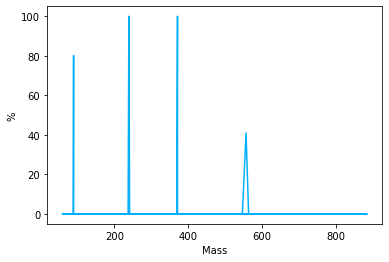

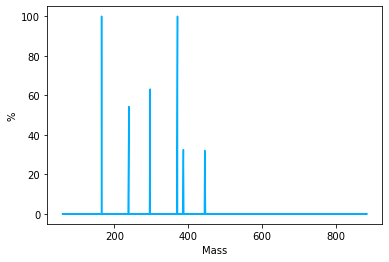

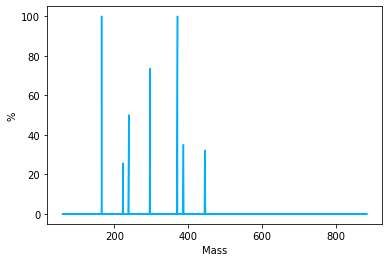

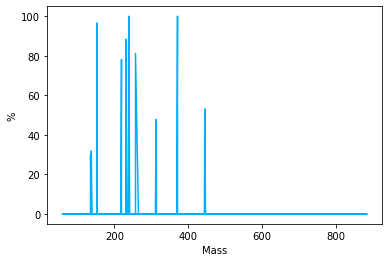

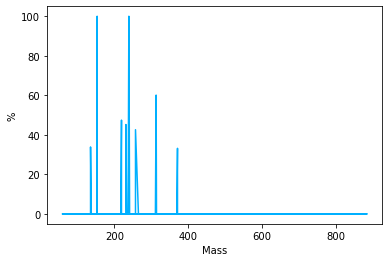

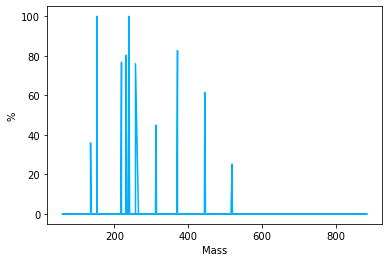

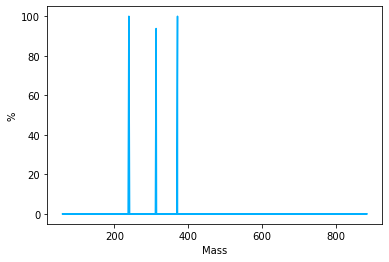

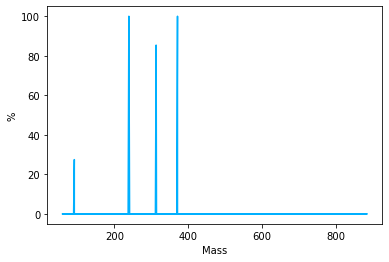

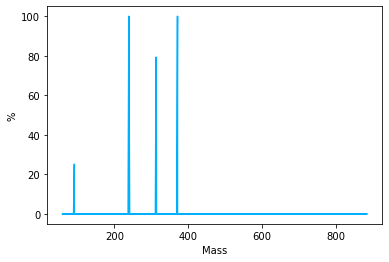

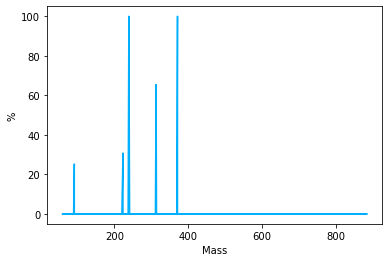

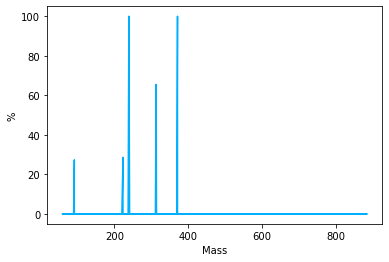

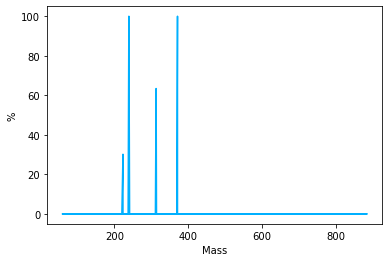

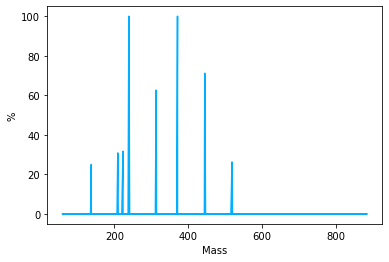

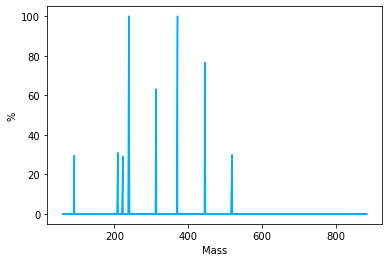

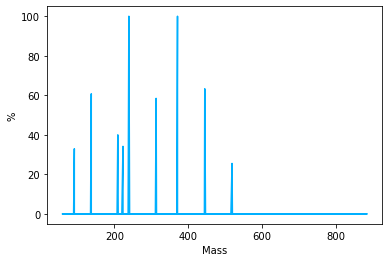

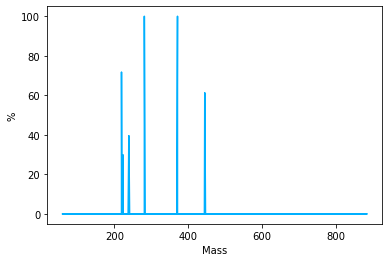

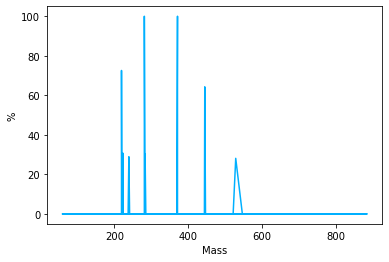

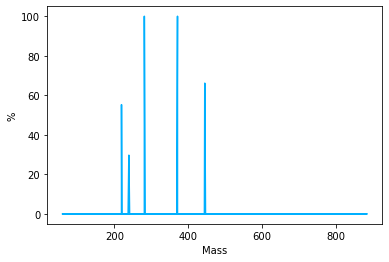

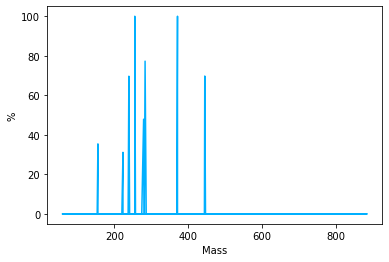

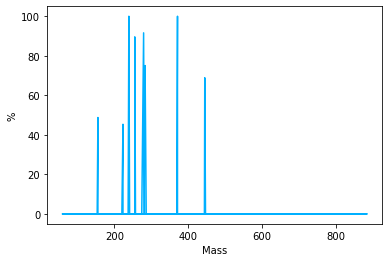

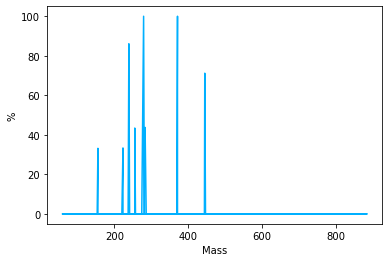

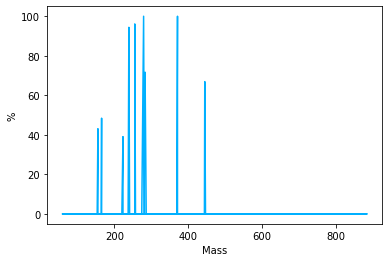

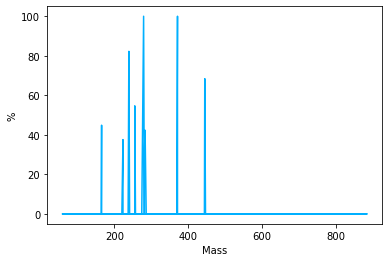

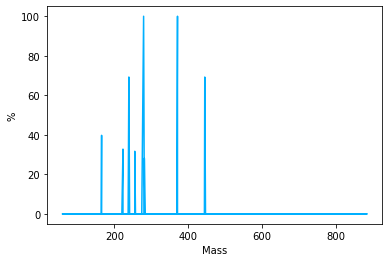

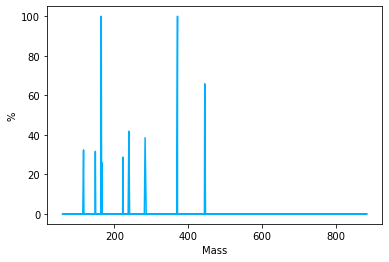

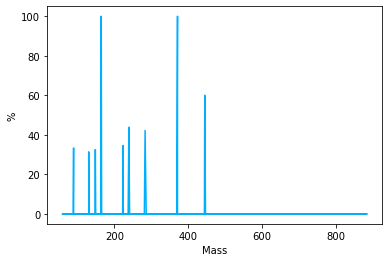

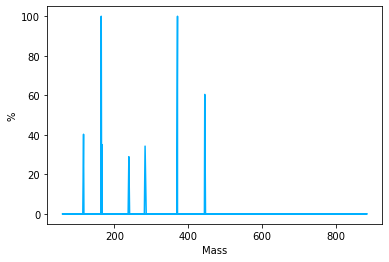

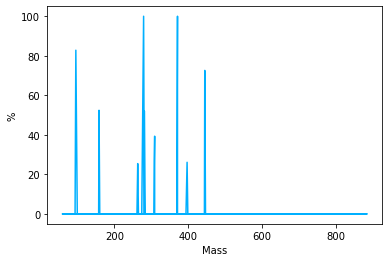

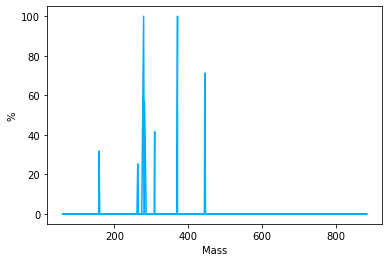

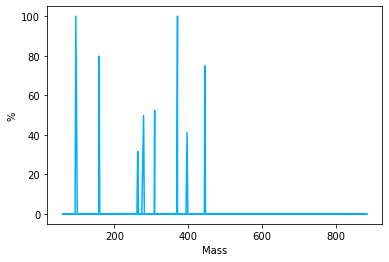

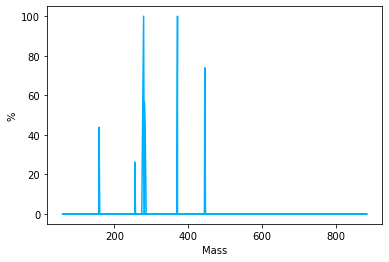

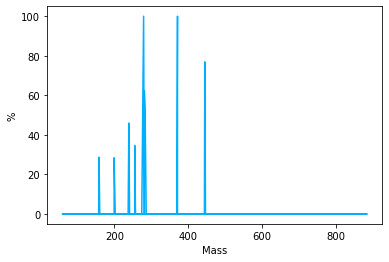

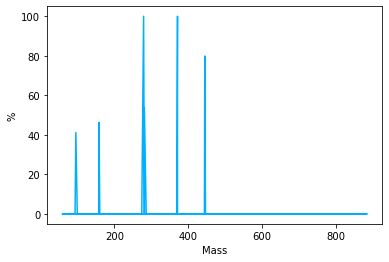

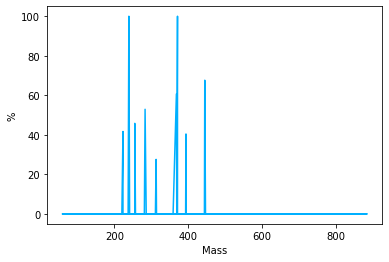

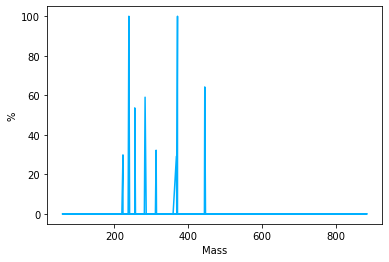

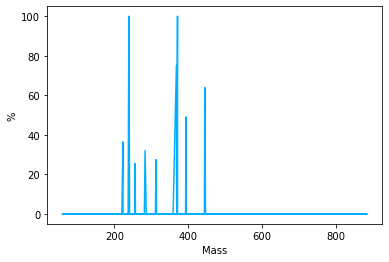

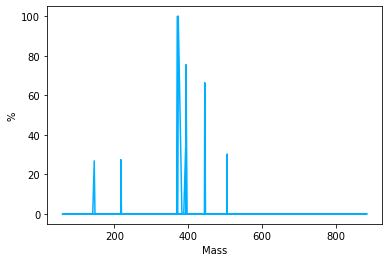

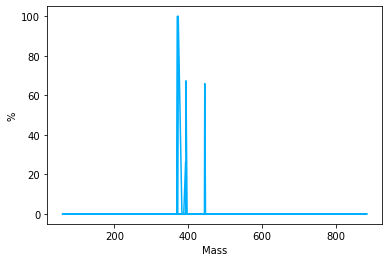

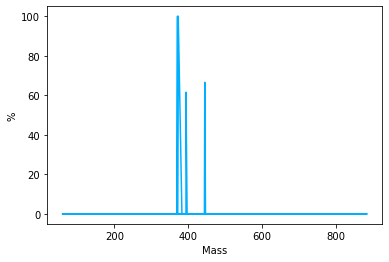

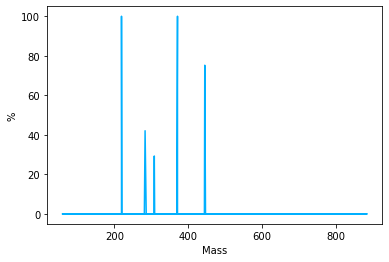

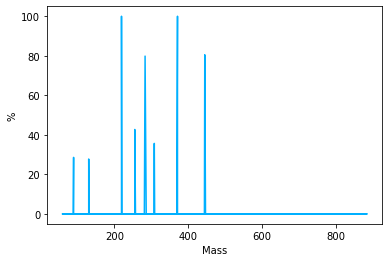

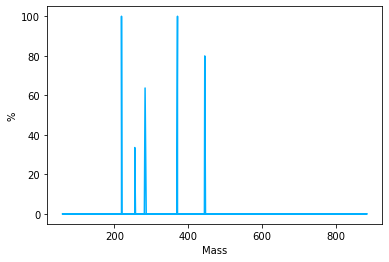

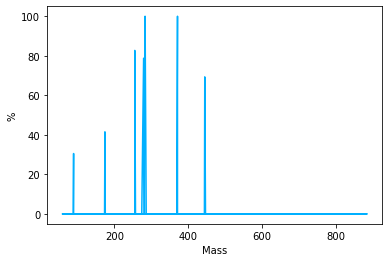

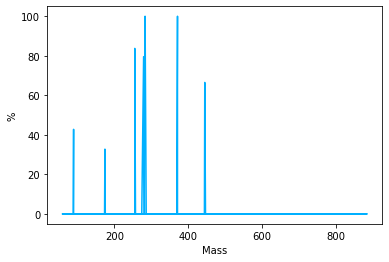

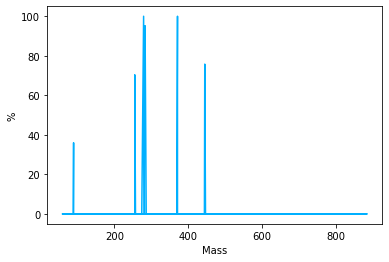

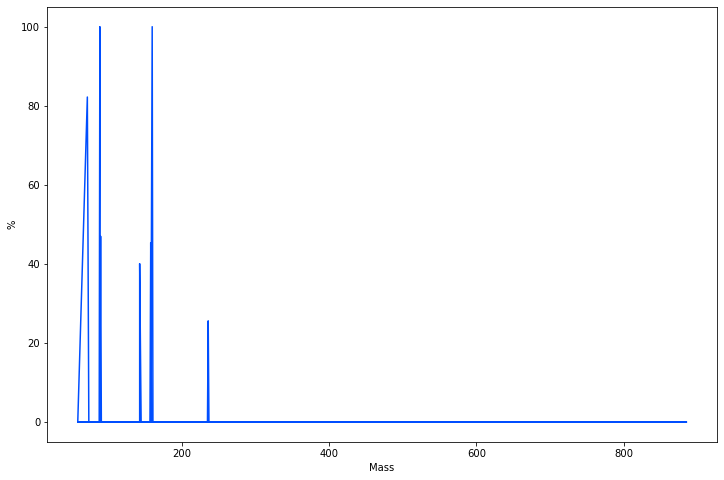

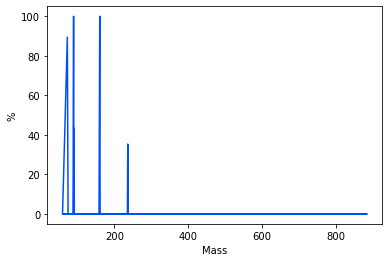

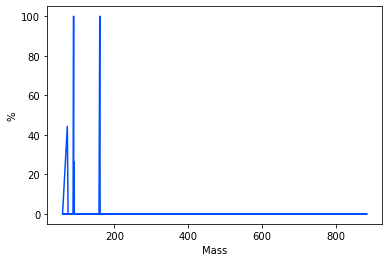

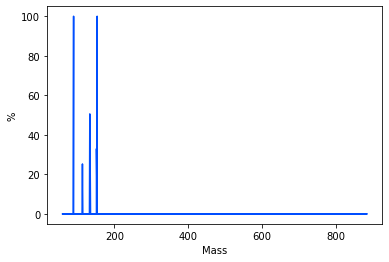

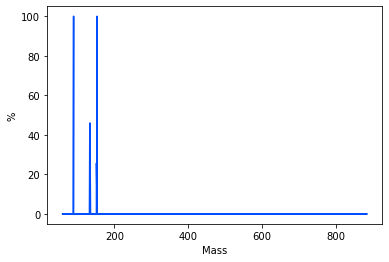

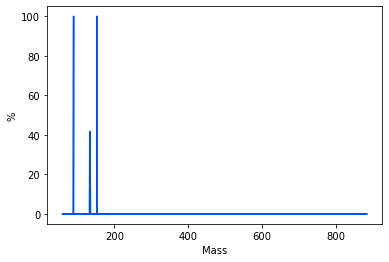

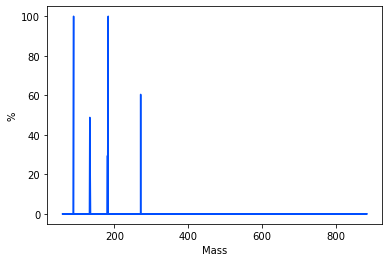

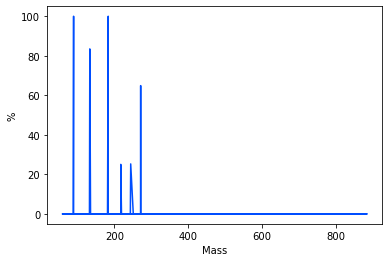

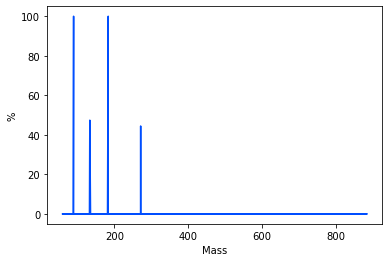

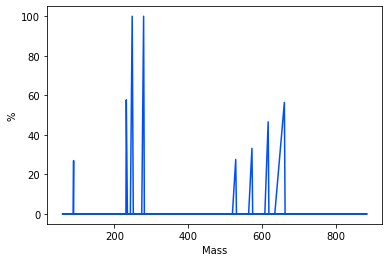

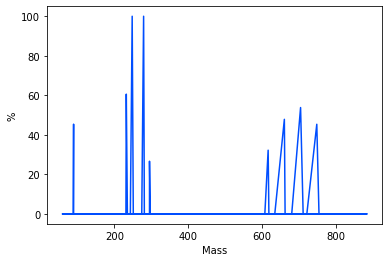

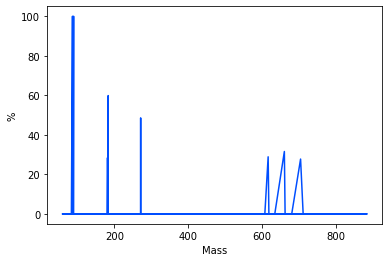

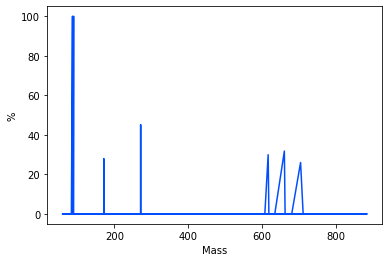

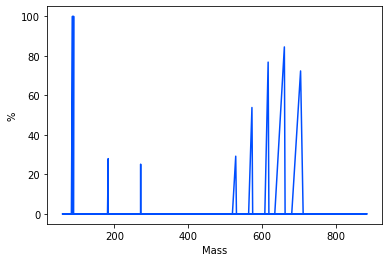

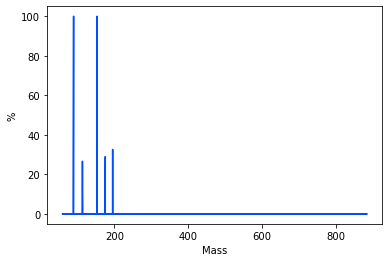

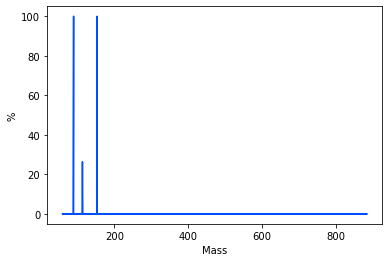

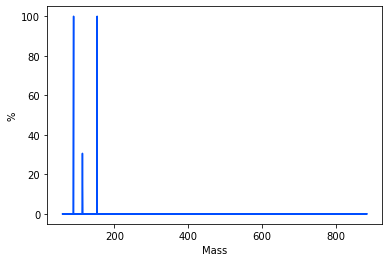

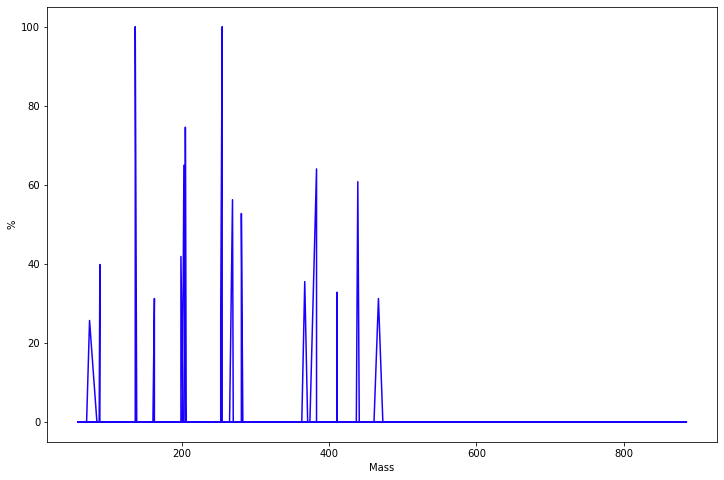

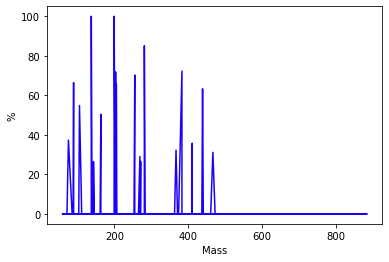

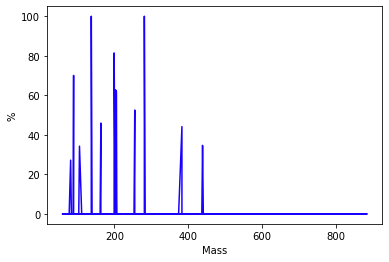

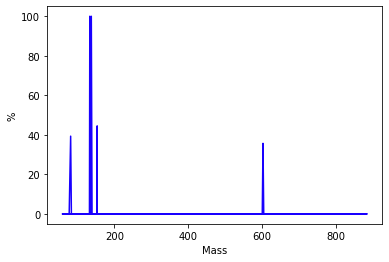

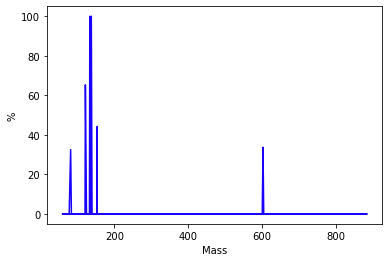

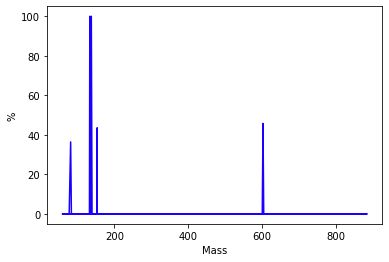

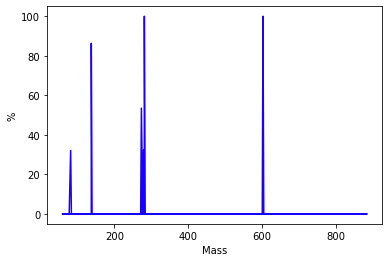

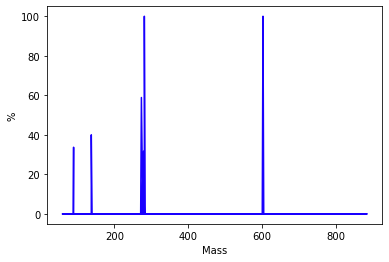

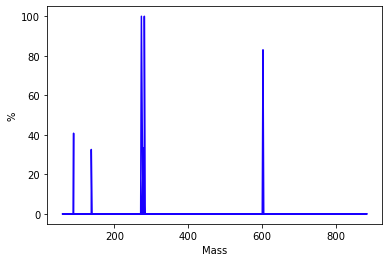

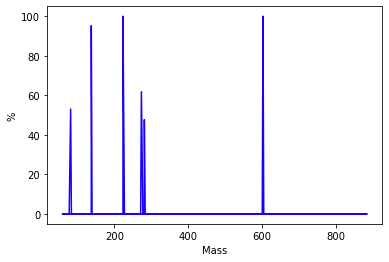

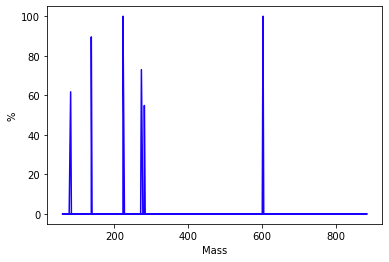

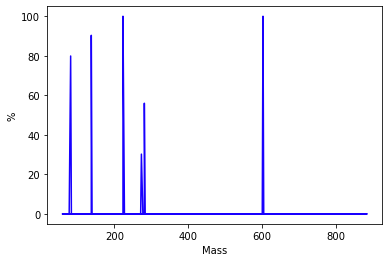

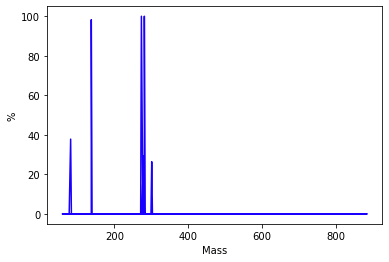

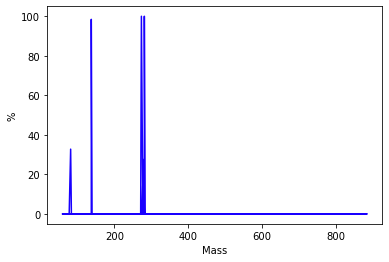

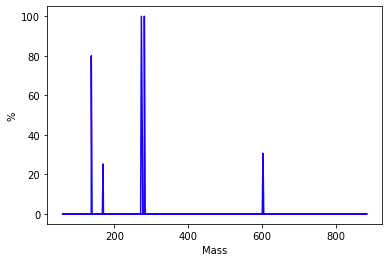

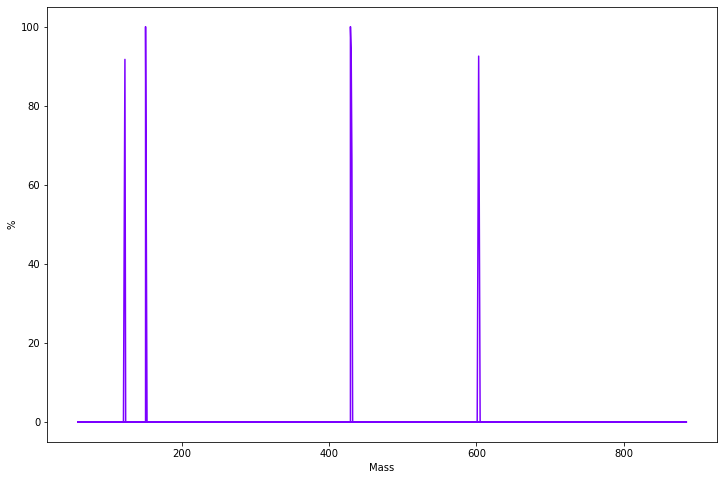

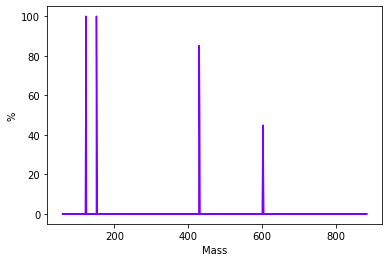

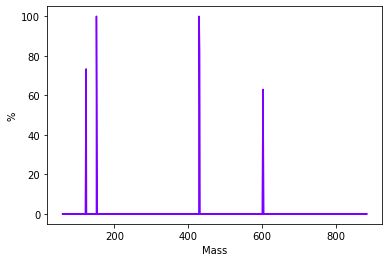

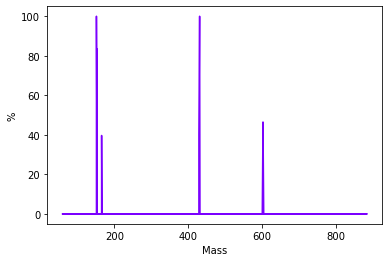

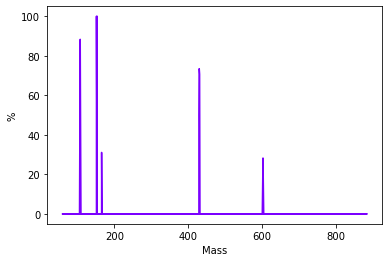

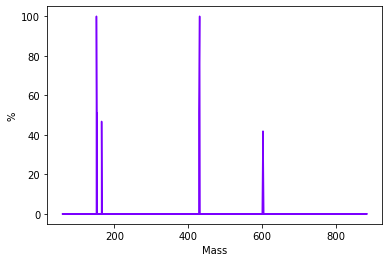

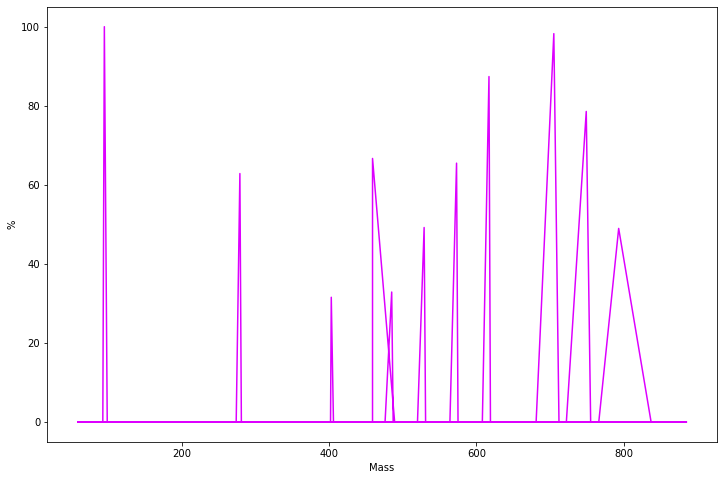

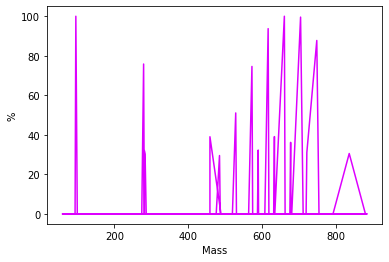

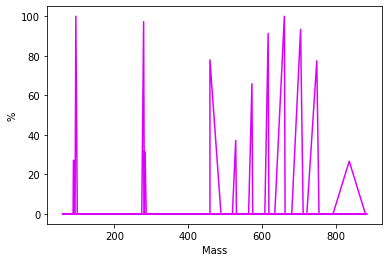

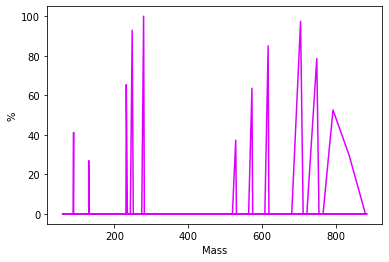

In [17]:
import pylab

labeled_df = df[df['Sample Types'] == 'Model']
recol = [(float('.'.join(col.split('.')[:2])) if isinstance(col, str) else col) for col in df.columns[4:]]

unique_classes = labeled_df['Class'].unique()

NUM_COLORS = len(unique_classes)
cm = pylab.get_cmap('gist_rainbow')
cgen = (cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS))

for label in unique_classes:
    plt.figure(figsize=(12,8))
    mask = labeled_df['Class'] == label
    color = next(cgen)
    for ind, row in labeled_df.loc[mask, :].iterrows():
        data = row[df.columns[4:]].values
        data[data<25] = 0
        plt.plot(recol, data, color=color)
        plt.ylabel('%')
        plt.xlabel('Mass')
        plt.show()

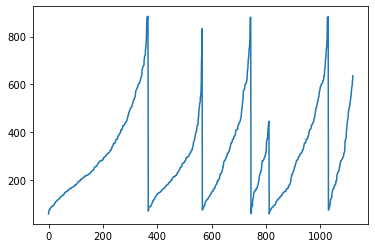

In [ ]:
# Rename numerical columns

recol = [(float('.'.join(col.split('.')[:2])) if isinstance(col, str) else col) for col in df.columns[4:]]
plt.plot(recol)

In [ ]:
recol

[59.00498,
 72.00792,
 74.00967,
 75.00427,
 77.00585,
 77.00646,
 81.00701,
 83.00489,
 86.00608,
 86.00967,
 87.00447,
 88.00758,
 89.00602,
 90.00918,
 91.00555,
 91.00773,
 93.00551,
 93.00712,
 95.00501,
 95.00863,
 98.00958,
 99.00799,
 100.00766,
 104.00713,
 105.00696,
 107.00477,
 109.01019,
 110.00593,
 110.00814,
 112.00517,
 113.0061,
 114.00923,
 116.00546,
 117.00554,
 117.00928,
 118.007,
 119.0072,
 120.00464,
 121.00301,
 121.00656,
 123.01192,
 124.0077,
 127.00413,
 129.00564,
 130.00871,
 130.016,
 131.00714,
 133.00649,
 133.0087,
 134.0083,
 135.0102,
 135.01171,
 137.00602,
 137.01347,
 139.00405,
 139.00756,
 139.01125,
 141.00559,
 145.01225,
 147.00665,
 149.00823,
 149.01331,
 150.01136,
 151.00974,
 151.01133,
 152.00726,
 152.01295,
 153.00565,
 153.0129,
 153.01136,
 155.01092,
 157.00439,
 157.01239,
 158.01548,
 160.01347,
 161.01286,
 163.0114,
 163.01472,
 164.01292,
 165.00673,
 165.00771,
 165.00906,
 166.00364,
 166.00889,
 167.00927,
 169.01069,
 1

It appears there are more than 3 measurement iterations? Why?

In [ ]:
Xcols = [f'Col{i}' for i in range(len(recol))]
df.columns = list(df.columns[:4]) + Xcols
df.head(n=10)

,Sample,Class,Sample Types,SRN,Col0,Col1,Col2,Col3,Col4,Col5,...,Col1111,Col1112,Col1113,Col1114,Col1115,Col1116,Col1117,Col1118,Col1119,Col1120
0,1,c1,Model,SRN00001_DART_NHM_1,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,c1,Model,SRN00001_DART_NHM_2,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,c1,Model,SRN00001_DART_NHM_3,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,c2,Model,SRN00002_DART_NHM_1,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,c2,Model,SRN00002_DART_NHM_2,0.0,0.0,0.0,5.83,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,c2,Model,SRN00002_DART_NHM_3,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,c3,Model,SRN00003_DART_NHM_1,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,c3,Model,SRN00003_DART_NHM_2,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,c3,Model,SRN00003_DART_NHM_3,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,c4,Model,SRN00004_DART_NHM_1,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df[df.columns[4:]].iloc[0:3]

,Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,...,Col1111,Col1112,Col1113,Col1114,Col1115,Col1116,Col1117,Col1118,Col1119,Col1120
0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data formatting

In [ ]:
def build_data_structure(df, labels, column_name_mass_locations):
    """
    Convert dataframe which has columns of the mass locations and values of the intensities
    to array format where the sample is a list of peaks and the samples are grouped by the number of peaks.

    Input:
    df: dataframe with columns of the mass locations and values of the intensities
    	Col0  Col1  Col2 ...
    0	0.0	  0.0	0.0

    column_name_mass_locations: column names of the mass locations
    [59.00498,
     72.00792,
     74.00967,
     ...
    ]

    We split it up just in case duplicate mass locations are present since multiple scans can be represented.

    Output:
    [ [samples with smallest number of peaks],
      [samples with 2nd smallest number peaks], 
      ...,
      [samples with largest number of peaks]
    ]

    where each sample is an array of lists (mass, intensity):
    array([[peak_location1, peak_intensity1], [peak_location2, peak_intensity2], ...])
    """
    df = df.copy()
    # Get nonzero values (aka "peaks")
    data = df.apply(lambda x: np.asarray([[column_name_mass_locations[i], val] for i, (val, b) in enumerate(zip(x, x.gt(0))) if b]), axis=1)    

    X = []
    Y = []
    # Group so we have groups of the same number of peaks
    lengths = np.array([len(x) for x in data])
    unique_lengths = np.unique(lengths)
    for length in unique_lengths:
        mask_length = lengths == length
        mask_idx = np.where(mask_length)
        y = labels[mask_idx]
        x = np.stack(data.loc[mask_length].values.tolist())
        X.append(x)
        Y.append(y)
    return X, Y

labeled_df = df[df['Sample Types'] == 'Model']
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(labeled_df['Class'].unique())
X, Y = build_data_structure(labeled_df[labeled_df.columns[4:]], labeled_df['Class'].values, recol)
y = [lb.transform(y) for y in Y]
len(X), X[0].shape, len(y), y[0].shape

(59, (4, 15, 2), 59, (4, 14))

## Investigate test-train partition

In [ ]:
df['Sample Types'].value_counts()

Model    336
Test     150
Name: Sample Types, dtype: int64

In [ ]:
df['Class'].value_counts()

c3     52
c10    48
c4     36
c5     36
c1     35
c6     28
c9     21
c7     20
c11    17
c12    15
c2     12
c8      6
c13     6
c14     4
Name: Class, dtype: int64

In [ ]:
df[df['Sample Types'] == 'Model']['Class'].value_counts()

c3     52
c10    48
c4     36
c5     36
c1     35
c6     28
c9     21
c7     20
c11    17
c12    15
c2     12
c8      6
c13     6
c14     4
Name: Class, dtype: int64

In [ ]:
df[df['Sample Types'] == 'Test']['Class'].value_counts()

Series([], Name: Class, dtype: int64)

## Seeing no labels in the Test split, we must split the train for a supervised evaluation

In [ ]:
labeled_df = df[df['Sample Types'] == 'Model']

X = build_data_structure(df[df.columns[4:]])

from sklearn import model_selection
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(labeled_df['Class'])

train_labeled_df, test_labeled_df = model_selection.train_test_split(labeled_df, train_size=None, shuffle=True, stratify=labeled_df['Class'])

X_train = build_data_structure(train_labeled_df[train_labeled_df.columns[4:]])
X_test = build_data_structure(test_labeled_df[test_labeled_df.columns[4:]])

y_train = lb.transform(train_labeled_df['Class'])
y_test = lb.transform(test_labeled_df['Class'])

TypeError: build_data_structure() missing 2 required positional arguments: 'labels' and 'column_name_mass_locations'

In [ ]:
print(len(X_train), len(X_test))

print(X_train[12][0].shape, y_train[0].shape, X_test[12][0].shape, y_test[0].shape)

53 38
(27, 2) (14,) (29, 2) (14,)


In [ ]:
from core import RealDataGenerator

gen = RealDataGenerator(
    X_train, y_train,
    X_test, y_test,
    X_test, y_test
)



TF version: 2.5.0
TF running in graph mode


AttributeError: 'list' object has no attribute 'shape'